# WikiRecs
A project to recommend the next Wikipedia article you might like to edit

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import wikipedia
import requests
import os
import wikirecs as wr
import implicit
from scipy.sparse import csr_matrix, csc_matrix, lil_matrix
from tqdm.auto import tqdm
import umap
import pickle
import collections
import recommenders
import plotly.express as px
from pyarrow import feather

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 100)

In [3]:
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

In [4]:
cols = ['userid', 'user', 'pageid', 'title',
       'timestamp', 'sizediff']


# Get recent changes (to get a list of users)

In [37]:
# df = wr.get_sample_of_users(edit_lookback=100000, outfile="sampled_users.pickle")

Earliest timestamp: 2021-02-11T05:35:34Z
Latest timestamp: 2021-02-11T05:38:35Z
Number of distinct users: 72
Number of distinct users: 72
Mean number of edits per user in timeframe: 1.39
Number of distinct pages edited: 89
Mean number of edits per page in timeframe: 1.12


user    userid
0            Another Believer   5886041
1                   Gardenkur  40527536
2               William Avery      1398
3                    Nexus000  20212957
4                   Drones100  41173297
5                      053pvr  41042556
6                    JCwiki21  14633420
7            CommonSentiments  27015145
8                   MarnetteD    220924
9                    Gummycow  40751078
10             Wherelovelives  12283949
11                  Rosiestep   4564448
12               Chandan Guha   8754091
13                   Dyaluk08  32254887
14                ChuckieFigh  38682593
15  Taylor Riastradh Campbell  31697869
16              Lieutcoluseng  19430894
17                 Jjjjjjjjjj    751520
18                Blazewing16  34193108
19             I hav ur pants  41198174
20                   Jevansen   2842084
21              MatthewHoobin  18313966
22                  Megacheez  25353172
23                TnT20052013  32900191
24             Gaseous OBJECT  41198104
25                   KConWiki   1994682
26               MainlyTwelve   1487243
27                  George100   1032465
28                        N2e   1143897
29            GeorgeStark1985  37737371
30          Anachronistic 328  41197792
31                    GoodDay    589223
32                      OCJ77  41074482
33          Moscow Connection  10352489
34                    Xiamatt  40553168
35           Originalchampion  19214637
36                   Elinruby   2044340
37                HeinzMaster  31737867
38                     Fyrael   6675779
39                     Gjs238    486612
40                    Wjp1134  26270848
41                Petewarrior    369638
42                    AzulD20  41033086
43                  Kawagishi   5563948
44                     245CMR  39680757
45               Eh Oh Canada  11693895
46                HarryKernow  26391060
47                ShelfSkewed   1152308
48                    Mjroots    408438
49                   Intelfan  39416402
50                BobKilcoyne   7770027
51            Yoga Widya 1994  26153673
52                Nevermore27   1788296
53              Kerry Raymond    300735
54                  Johnj1995  33582946
55                     Buaidh    122305
56                 Thricecube   1019695
57                    Myconix  18578793
58                 Mitch Ames   6326132
59                GoldenGuy23  21430182
60           Lonniemitchell22  32731203
61            Needforspeed888  22179980
62               FyzixFighter    414998
63                Lcmortensen    339722
64                     Sc2353  36112485
65                   Muboshgu    602857
66                    Modokai  36342311
67                  Brianis19  17178606
68                   Mottezen  30705147
69            MaxwellMolecule  33839581
70               Psiƒ•edelisto  27502164
71                   Retimuko  31516478

In [272]:
# Check a user

wr.print_user_history(histories_train, user="Yoninah")

2019-12-30
 11:01:01 Monsey Hanukkah stabbing
 11:17:41 Siyum HaShas
 11:18:29 Siyum
 11:29:02 Monsey Hanukkah stabbing
 13:38:25 Die Himmel r√ºhmen des Ewigen Ehre
 13:42:02 Heino
 14:07:48 Kogin-zashi
 16:35:52 Chaim Malinowitz
 17:45:56 Mari√§ Kr√∂nung (Lautenbach)
 17:54:37 Progressive Slovakia
 18:02:10 Monsey Hanukkah stabbing
 20:31:23 All-you-can-eat seats
 20:42:35 Nebi Akasha Mosque
 20:44:29 Monsey Hanukkah stabbing
 20:47:46 Independence (steamboat)
 21:34:26 Caton Oak
 21:40:28 Byblos figurines
 21:50:34 Temple of Baalat Gebal
 21:51:21 Temple of the Obelisks
 22:00:50 Leah Stokes
 22:05:52 Monsey Hanukkah stabbing
 22:13:17 Byblos figurines
 22:13:48 Temple of the Obelisks
 22:14:44 Temple of Baalat Gebal
 22:16:00 Monsey Hanukkah stabbing
 23:49:46 Chaim Malinowitz
 23:51:28 Monsey Hanukkah stabbing
2019-12-31
 11:50:55 Siyum HaShas
 11:58:30 Monsey Hanukkah stabbing
 13:13:27 Chaim Malinowitz
2020-01-01
 00:11:25 Chaim Malinowitz
 00:24:15 Jew in the City
 00:27:36 Siyu

 19:41:00 Almira Sessions
 19:46:41 Gary Cooper
 21:27:24 Good Sam (1948 film)
 21:33:34 Dick Wessel
 21:37:19 Ida Moore
 22:17:21 Good Sam (1948 film)
 23:46:17 Harpo Marx
 23:47:26 Nachman of Breslov
2020-01-30
 00:43:10 Tokyo Joe (film)
 00:43:34 Between Midnight and Dawn
 00:44:23 Lady at Midnight
 00:46:00 Mighty Joe Young (1949 film)
 00:46:42 Paid in Full (1950 film)
 00:47:38 Good Sam (1948 film)
 00:48:39 Mr. Soft Touch
 00:50:08 The Snake Pit
 00:58:01 Lora Lee Michel
 01:01:44 Schulenburg, Texas
 01:03:12 Lora Lee Michel
 01:18:54 Good Sam (1948 film)
 10:51:57 Orobanche reticulata
 10:57:29 John Altobelli
 11:03:03 Lora Lee Michel
 11:37:41 Good Sam (1948 film)
 12:00:03 John Altobelli
 14:01:07 Good Sam (1948 film)
 19:33:20 Gasklockan, Gothenburg
 19:45:45 W. G. Hardy
 20:03:17 John Altobelli
 20:16:29 Grotta del Gelo
 20:41:46 The Minute Man
 22:06:37 Acer diabolicum
 22:13:12 That's the Woman I Want
 22:33:28 Bleach: Brave Souls
 22:46:25 Karim Vahed
 23:13:59 Teno Ronc

 23:36:32 Eva Lee Kuney
2020-02-24
 00:01:58 Eva Lee Kuney
 14:04:08 Penny Serenade
 14:31:26 Eva Lee Kuney
 18:21:43 Bringing Up Baby
 20:13:18 Eva Lee Kuney
 20:16:42 Munchkin
 20:53:02 Eva Lee Kuney
 23:52:10 Tayseer Sboul
 23:57:32 Suki Lopez
2020-02-25
 00:18:07 Brendan Kavanagh
 00:24:17 Nelly Ben-Or
 02:07:43 List of Under-19 Cricket World Cup centuries
 02:28:49 The Goes Wrong Show
 13:27:50 William Harper Carter
 14:09:18 Heinz Schnabel and Harry Wappler escape attempt
 14:14:55 List of American former child actors
 17:56:10 Psalm 51
 19:24:33 The Piano Guys
 21:37:31 Zina P. Young Card
 21:39:15 ≈ûƒ±rnak Silopi power station
 22:00:37 The Right Side of History
 22:29:22 Bad Idea (song)
2020-02-26
 18:30:06 Energy policy of Turkey
 18:46:51 Ishay Ribo
 18:51:06 Zina P. Young Card
 18:58:55 William Harper Carter
 19:35:50 Tom Hanks
 23:53:25 Piazza Scossacavalli
2020-02-27
 12:49:29 Magdalena K. P. Smith Meyer
 21:06:21 Danish Trade Union Confederation
 21:59:15 Vancouver Hebre

2020-03-29
 12:20:03 COVID-19 pandemic in Israel
 17:21:58 Queen Bess, Scunthorpe
 18:52:21 COVID-19 pandemic in Israel
 19:23:31 Chef (2014 film)
 21:44:12 Gregory Peck on screen, stage and radio
 22:07:20 Pompton Junction station
 22:24:17 White-browed tit-warbler
 22:49:33 John Conyers
 22:54:59 Shakespeare and Star Trek
 23:11:03 COVID-19 pandemic in Israel
2020-03-30
 10:16:33 Monsey Hanukkah stabbing
 12:47:02 Colin Clinton
 18:33:16 COVID-19 pandemic in Israel
 19:14:09 Catch It, Bin It, Kill It
 19:16:36 Swine Flu Skank
 20:56:03 J. C. "Sonny" Gilbert Wildlife Management Area
2020-03-31
 21:07:17 COVID-19 pandemic in Israel
2020-04-01
 13:53:16 COVID-19 pandemic in Israel
 16:05:34 Sufganiyah
 18:27:13 Teik≈ç Shiotani
 19:19:42 COVID-19 pandemic in Israel
 19:56:13 Ishay Ribo
 22:33:11 University of Colorado Denver
 22:39:25 Dorothy Horrell
 22:48:13 Holyoke, Colorado
 22:56:56 Dorothy Horrell
 23:40:16 New Albion
 23:53:03 Dorothy Horrell
 23:58:33 Holyoke, Colorado
2020-04-02

 19:14:37 Ruby Mazur
 19:30:33 Mir Jumla III
 19:42:48 Patsy Mink
 19:57:57 How I'm Feeling Now
 20:16:00 432 Park Avenue
 20:48:31 Calamintha sylvatica
 21:11:51 N95 respirator
 21:27:39 COVID-19 pandemic in Israel
2020-04-27
 09:01:28 It's a Crime (play-by-mail game)
 09:25:20 Mohsen Shaalan
 12:06:24 Breslov Research Institute
 15:16:17 Zion Blumenthal Orphanage
 15:37:08 Marriage bed of Henry VII
 15:41:21 Neil Malhotra
 15:49:19 Ha ªaheo Kaniu
 16:26:43 That Brennan Girl
 19:08:42 Cable Haunt
 19:34:54 Toxic Beauty
 19:50:51 Eddy Sabara
 20:01:02 ≈öƒÅriputra
 20:17:35 Ernest Berry Webber
 20:31:24 Mount Brandon
 21:02:08 San Filippo Neri in Via Giulia
 21:12:03 Disappearance of Don Lewis
 22:32:13 Bad Girl (1931 film)
 22:35:40 James Dunn (actor)
 22:53:15 Follow the Sun (TV series)
2020-04-28
 00:02:25 Follow the Sun (TV series)
 11:40:58 Renate Br√ºmmer
 13:18:19 Vichna Kaplan
 22:11:05 Archie, Marry Me
2020-04-29
 00:02:10 Baby Take a Bow
 00:46:09 James Dunn (actor)
 02:02:52 

 13:13:48 Second Chance (1950 film)
 13:15:36 Paul F. Heard
 13:25:27 Swingin' Together
 13:30:15 Shadow Over Elveron
 13:31:42 Paul F. Heard
 15:25:40 Modern Art Foundry
 16:12:35 Bad Girl (1931 film)
 17:32:38 Bright Eyes (1934 film)
 19:54:57 Fannie Flagg
 20:02:17 I Still Dream About You
 20:09:49 Real estate broker
 20:25:38 A Tree Grows in Brooklyn (1945 film)
 20:35:26 I Still Dream About You
 23:23:22 Protestant Film Commission
 23:46:54 Evelyn Brent
2020-05-19
 00:09:00 Second Chance (1950 film)
 00:14:53 Jimmy Hunt
 00:17:34 Erville Alderson
 00:21:35 Chayey Moharan
 00:24:16 Baruch Ben Haim
 00:27:01 Bad Girl (1931 film)
 10:44:11 Second Chance (1950 film)
 12:59:17 Likelike
 17:06:36 Pamela Chelgren-Koterba
 17:07:51 Annapolis, Maryland
 17:20:39 Autogenous pressurization
 17:49:05 Tourist tax
 19:00:43 Galcer√°n Bridge
 19:06:04 Hardcoded (video game)
 19:16:55 2002 PDC World Darts Championship
 20:31:09 Second Chance (1950 film)
 21:37:19 I Still Dream About You
 22:35:41

 21:21:48 Weekend Magazine
 21:24:02 Andy O'Brien (journalist)
 21:41:13 Alejandro Cruz (runner)
 21:49:14 Cecropia pachystachya
 21:51:10 Mauricio Gonz√°lez (runner)
 22:24:45 Laguna Creek watershed
2020-06-04
 15:03:02 James Dunn (actor)
 15:19:44 Thomas Lucas (educator)
 15:32:45 Fremantle Fortress
 15:44:13 My Name Is Han
 15:59:15 Yabu Meizan
 16:14:10 Bad Girl (1931 film)
 16:14:57 Have a Heart (film)
 16:15:33 Ginger (1935 film)
 16:16:28 The Blue Bird (1940 film)
 16:16:47 John R. Countryman
 16:17:28 Hold That Woman!
 16:18:21 Martin Spellman
 16:19:10 Paddy O'Day
 16:19:29 Pinky Tomlin
 16:19:55 Jane Withers
 16:20:37 The Living Ghost
 16:21:15 James Dunn (actor)
 16:22:08 Frances Gifford
 16:23:40 Alan Marshal (actor)
 16:24:04 Mary Grace Borel
 16:24:36 Barbara Billingsley
 16:25:06 Bruce Edwards (actor)
 16:26:21 David Bruce (actor)
 16:29:48 Prejudice (1949 film)
 16:33:28 James Dunn (actor)
 17:41:18 A Tree Grows in Brooklyn (1945 film)
 18:24:28 Zolt√°n Pesk√≥
 20:51:48

 21:06:02 Jyotigram Yojana
 21:19:41 Senior Citizens Partylist
 21:27:58 Race-reversed casting
 22:59:26 Stand Up and Cheer!
2020-06-23
 01:09:59 James Dunn (actor)
 01:11:17 Frances Gifford
 01:22:39 James Dunn (actor)
 10:45:09 Rhiannon Davies Jones
 11:42:40 Ng On-yee
 12:40:08 Newland Oak
 12:54:24 The Lot (album)
 14:56:10 Prejudice (1949 film)
 16:31:54 Isle of the Dead (Tasmania)
 16:43:59 Edward J. O'Donnell (military)
 17:11:58 James A. Baker (born 1857)
 17:39:20 Frank Clifford Rose
 18:11:59 Isahak Basir
 18:24:08 William Marsh Rice
 19:24:16 Art Tomassetti
 21:30:23 Burton Benedict
 22:24:25 How To: Absurd Scientific Advice for Common Real-World Problems
 23:11:59 Israel Isaac Kahanovitch
 23:14:17 Izzy Asper
 23:16:32 Louis Slotin
 23:17:23 Shmuel Abba Twersky
 23:18:02 Shaarey Zedek Synagogue (Winnipeg)
 23:30:53 Shaarey Zedek Cemetery (Winnipeg)
 23:55:22 Shaare Zedek
 23:56:16 Shaarey Zedek
 23:57:18 Congregation Shaarey Zedek
2020-06-24
 00:00:03 Hank Greenberg
 00:04:

2020-07-14
 08:28:07 Jimmy and Sally
 08:29:49 Albanese Candy
 08:59:12 South of the Clouds (1950 film)
 10:47:39 Roses and Castles
 12:10:29 Souleymane Mboup
 12:38:23 Chasing 3000
 14:40:27 Hello, Sister! (1933 film)
 15:41:25 Thirst trap
 18:06:50 Carlshof Institutions
 18:29:01 Moral (1982 film)
 18:57:20 Killing of Manuel Ellis
 20:31:14 2 Black 2 Strong
 20:38:13 Carlshof Institutions
 21:57:54 Light a Penny Candle
 22:05:18 Real Life (novel)
 22:13:20 Brandon Taylor
 22:21:28 Light a Penny Candle
 22:28:25 Hello, Sister! (1933 film)
 23:15:08 1990 Cordillera Autonomous Region creation plebiscite
2020-07-15
 10:55:37 I can't breathe
 13:16:19 Nathalie Evans
 13:33:01 Winifred Tumim
 13:39:00 UpCounsel
 18:41:21 Stephanie Pollack
 19:24:18 Mooky Greidinger
 19:37:44 Chabad of Poway
 21:27:09 Leickness Simbayi
 22:11:18 Chabad of Poway
2020-07-16
 10:30:53 Mexican music in Chile
 10:42:43 South of the Clouds (1950 film)
 11:00:06 Adesh Kumar Gupta
 11:12:50 Chabad of Poway
 11:13:3

 00:09:49 Edward B. Foley
 00:30:39 Autobahnkirche Siegerland
 00:49:39 Akira Fudo
 11:33:33 Joaqu√≠n Bilbao
 16:58:15 LaNada War Jack
 17:32:47 Joaqu√≠n Bilbao
 18:13:05 Akira Fudo
 21:43:43 Syrian Jewish communities of the United States
 22:02:32 Beit Harambam Congregation
 22:35:26 Syrian Jewish communities of the United States
 23:16:17 Beit Harambam Congregation
 23:37:43 Jawdhar
 23:41:34 Johnny Doughboy
2020-08-28
 00:46:01 Albert Gabbai
 14:58:21 Origins of the Hermit Friars of the Order of Saint Augustine and Their True Establishment Before the Great Lateran Council
2020-08-29
 18:33:48 Siege of Trichinopoly (1743)
 19:37:41 Folklore (Taylor Swift album)
 19:46:38 Gorkha Bridge
 20:16:34 Heartbroken Angels
 20:23:02 Stuart Threipland
 20:55:01 Myrichthys maculosus
 21:08:12 Prince Baltasar Carlos in the Riding School
 21:11:31 Alonso Mart√≠nez de Espinar
 21:14:57 Pedro Perete
 21:42:24 Maimonides
 21:51:52 Ben Shapiro
 22:36:19 Siege of Trichinopoly (1743)
 22:44:23 Aeolidiel

2020-09-18
 14:49:07 The Ghost and the Guest
2020-09-20
 18:56:36 Melinda Plowman
 18:58:37 The Ghost and the Guest
 19:04:15 Weathering with You
 19:25:29 Hermann Deiters
 20:45:12 Raissa Calza
 20:53:58 The Ghost and the Guest
 21:07:33 Jeanne Humbert
 21:57:08 Pop Maynard
 22:21:56 Korea Central Zoo
 22:25:45 The Ghost and the Guest
 23:31:08 Three warfares
 23:31:08 Three Warfares
 23:38:02 Chinese information operations and information warfare
 23:39:22 Three warfares
2020-09-21
 00:16:46 Benny Friedman (singer)
 11:14:14 Ruth Bader Ginsburg
 12:24:05 Yumeji Takehisa
 12:42:43 Randall Lane (journalist)
 13:38:47 Siege of Trichinopoly (1743)
 14:12:20 Kolkata Suburban Railway
 14:25:55 Rodney Scott's Whole Hog BBQ
 14:25:55 Rodney Scott's BBQ
 14:26:25 James Beard Foundation Award
 14:26:55 Chef's Table
 14:27:16 Food Paradise (season 12)
 15:54:50 Robert F. Utter
 17:01:53 Aran Bell
 17:13:03 Virtual YouTuber
 17:27:26 Aran Bell
 17:48:06 Flag of Western Australia
 18:24:51 Annett

 23:59:04 Thomas Payne (soldier)
2020-10-11
 00:02:17 Thomas Payne (soldier)
 10:35:12 Yaakov Perlow
 12:29:37 Sinfonietta (Poulenc)
 17:06:56 Gretchen Whitmer kidnapping plot
 18:06:25 Spendius
 19:19:37 List of Arjuna Award recipients (2000‚Äì2009)
 20:26:57 The Interior of the Palm House on the Pfaueninsel Near Potsdam
 20:49:56 "Welcome to the LBJ Ranch!"
 21:12:18 James Dunn (actor)
 21:21:04 Children of Israel Cemetery
 21:23:13 The Interior of the Palm House on the Pfaueninsel Near Potsdam
 23:03:04 The General (1926 film)
2020-10-12
 13:52:02 Meshulam Eliezer Leifer
 13:58:12 James Dunn (actor)
 14:00:21 Mickey Rooney
 14:01:10 James Dunn (actor)
 15:20:30 California Border Protection Stations
 15:51:58 The Sociology of Housework
 16:20:06 Tom Kennedy (television host)
 16:22:58 The Sociology of Housework
 22:25:35 Framber Valdez
 22:44:17 Krishna Lal Adhikari
 23:25:49 Makaiko Kheti
 23:52:37 Faur√© Quartet
 23:59:25 Sven Helbig
2020-10-13
 00:01:20 Wesley O. Smith
 00:11:10 C

 03:07:19 Exhibit A: Secrets of Forensic Science
 12:32:23 Adalet Cimcoz
 12:48:59 Jane Withers
 13:11:48 Nabil Ahmad
 13:14:53 Jane Withers
 14:15:19 Adalet Cimcoz
 15:09:09 Minbar of the Ibrahimi Mosque
 15:29:46 Pressburg Yeshiva (Jerusalem)
 15:38:56 Election apportionment diagram
 15:46:10 Jane Withers
 16:28:44 Sailor's Luck
 17:20:41 James Biggart
 17:30:51 Malcolm Todd
 17:54:55 Sailor's Luck
 20:59:38 Cherry, Cherry
 21:07:03 Longfellow Serenade
 21:08:30 Neil Diamond
 22:31:01 Carpentras Stele
 22:38:13 Illinois Public Access Opinion 16-006
 22:48:32 State-of-the-Art Car
 22:56:17 Stefania Berlinerblau
 23:12:10 John F. Yardley
 23:19:29 The Thirty-Year Genocide
 23:43:28 Dayahang Rai filmography
 23:59:23 Sailor's Luck
2020-11-04
 00:01:41 Sailor's Luck
 16:25:04 Robin Hood's Well
 17:24:54 John F. McCarthy Jr.
 17:30:31 List of Massachusetts Institute of Technology alumni
 17:45:44 Pact of Free Cities
 19:48:20 Sailor's Luck
 21:30:23 Jane Withers
 22:44:37 Hot stove league

 17:36:51 Air pollution in Turkey
 19:33:18 Smokey Robinson
 19:42:18 Katie Lachapelle
 20:55:02 Reuven Fahn
2020-11-26
 00:17:18 Rebecca (1940 film)
 01:02:25 Houkje Gerrits Bouma
 01:33:18 The Divorce of Lady X
 13:08:55 Katie Lachapelle
 13:08:56 Katie LaChapelle
 13:10:07 Holy Cross Crusaders women's ice hockey
 13:12:26 Katie Lachapelle
 18:35:54 University of Calcutta
 22:55:43 Women's poll tax repeal movement
 23:09:30 Florence Lewis (activist)
2020-11-27
 00:00:25 Jean Le Patourel
2020-11-28
 16:42:36 Reuven Fahn
 16:52:12 Shlomo Chanoch Rabinowicz
 17:19:34 Mary Fowkes
 17:21:45 Clayton, New York
 17:38:05 National indifference
 17:46:43 Jones Hill Wood
 18:17:42 Tarabya I of Pakhan
 18:33:24 Sufganiyah
 19:36:30 Piotr Potworowski
 19:56:09 Arnold Wolfers
 20:18:05 Eric Kimaiyo
 20:39:59 Statue of Heydar Aliyev, Mexico City
 20:48:39 Verrucosa arenata
 20:58:23 The Indelicates
 21:03:41 Death and state funeral of Ruth Bader Ginsburg
 21:27:25 Yeshiva Beth Yehudah
 22:08:02 Lis

 12:08:49 William Gates LeDuc
 12:21:04 Geoffrey Massey
 12:28:36 Dick Kaegel
 12:37:37 Ruach (Kabbalah)
 13:08:40 Tenth of Tevet
 14:02:05 Body (Megan Thee Stallion song)
 17:40:01 Safari Hotel
 18:04:46 Kandy Tuskers in 2020
 18:29:08 Tenth of Tevet
 19:45:46 Your Mother's Son-In-Law
 20:05:03 Herman Asaribab
 20:23:49 The Next Corner
 21:15:42 Gertrude Degenhardt
 21:23:01 Manner (company)
 21:30:28 Die Schutzbefohlenen
 21:49:02 John Montgomery Cooper
 22:19:21 Violet Crowther
2020-12-21
 03:05:27 Alexandrea Owens-Sarno
 12:41:30 John Montgomery Cooper
 15:32:42 Harry Field (American football)
 15:36:39 Psalm 148
 18:14:35 Kandy Tuskers in 2020
 18:21:20 Mordechai Yissachar Ber Leifer
 18:28:48 Gonen Ben Itzhak
 18:30:51 Mosab Hassan Yousef
 18:43:44 Gonen Ben Itzhak
 19:41:33 2021 Uzbek presidential election
 19:52:52 Deb Price
 21:02:32 Galle Gladiators in 2020
 22:50:21 Rodrigo Maroni
 23:04:13 LaVon Mercer
 23:32:41 SSA impersonation scam
2020-12-22
 00:09:45 Soetran
 13:43:33 

In [ ]:
# Change column types

all_histories.loc[:,'userid'] = all_histories.loc[:,'userid'].astype(int)

all_histories['title'] = all_histories['title'].astype(str)

In [ ]:
wr.save_pickle(all_histories,"../all_histories.pickle")

# Load all_histories (raw data), transform and split 

In [88]:
%%time
all_histories = wr.load_pickle('../all_histories.pickle')

print("Length raw edit history data: {}".format(len(all_histories)))

Length raw edit history data: 14998090
CPU times: user 11.6 s, sys: 10.9 s, total: 22.6 s
Wall time: 26.6 s


In [79]:
## Add one particular user

with open("../username.txt", "r") as file:
    username = next(file)

oneuser = wr.get_edit_history(user=username,
                    latest_timestamp="2020-12-30T02:02:09Z",
                    earliest_timestamp="2019-12-30T02:02:09Z")
oneuser = pd.DataFrame(oneuser).loc[:,cols]
all_histories = pd.concat([all_histories, oneuser], ignore_index=True)

print("Length after adding one user: {}".format(len(all_histories)))

Length raw edit history data: 14998090
Length after adding one user: 14998470
CPU times: user 30.1 s, sys: 29.9 s, total: 59.9 s
Wall time: 1min 29s


## EDA on raw histories

In [46]:
# Look at the distribution of edit counts
edit_counts = all_histories.groupby('userid').userid.count().values

Median edit counts: 135
Number over threshold 5: 9558 (83%)


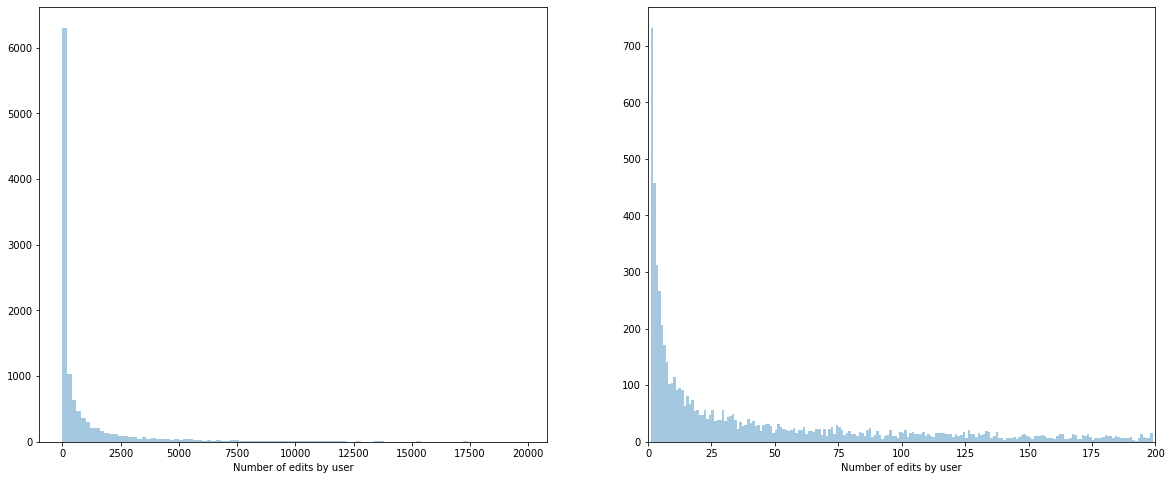

In [48]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.distplot(edit_counts,kde=False,bins=np.arange(0,20000,200))
plt.xlabel('Number of edits by user')
plt.subplot(1,2,2)
sns.distplot(edit_counts,kde=False,bins=np.arange(0,200,1))
plt.xlim([0,200])
plt.xlabel('Number of edits by user')
num_counts = len(edit_counts)
print("Median edit counts: %d" % np.median(edit_counts))
thres = 5
over_thres = np.sum(edit_counts > thres)
print("Number over threshold %d: %d (%.f%%)" % (thres, over_thres, 100*over_thres/num_counts))

In [49]:
# Most edits by user
all_histories.groupby(['userid','user']).userid.count().sort_values(ascending=False)

userid    user                          
1276024   Lugnuts                           100000
28779459  Lepricavark                        99989
7611264   AnomieBOT                          99960
1261736   Red Director                       99673
7852030   Materialscientist                  99637
196446    BD2412                             98184
937705    Iridescent                         94032
1544984   Dawnseeker2000                     92428
1189543   Simeon                             91939
753665    Ser Amantio di Nicolao             82123
525927    Chris the speller                  75883
5718152   Arjayay                            67039
917223    Dl2000                             63156
96340     Markussep                          61272
22041646  Narky Blert                        60731
26021349  MB                                 58959
2278355   Keith D                            57307
7098284   Tassedethe                         52503
11308236  John of Reading                

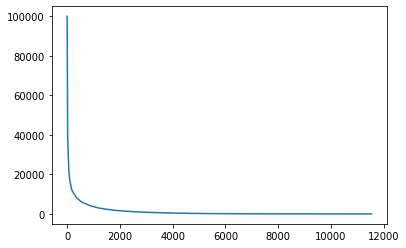

In [50]:
# Find the elbow in number of edits
plt.plot(all_histories.groupby(['userid','user']).userid.count().sort_values(ascending=False).values)
# plt.ylim([0,20000])

In [51]:
# What are the most popular pages (edited by the most users)
page_popularity = all_histories.drop_duplicates(subset=['title','user']).groupby('title').count().user.sort_values()

pd.set_option('display.max_rows', 1000)
page_popularity.iloc[-1000:].iloc[::-1]

title
COVID-19 pandemic                                                                          686
COVID-19 pandemic in the United States                                                     376
Deaths in 2020                                                                             375
2020 United States presidential election                                                   340
George Floyd protests                                                                      328
Coronavirus disease 2019                                                                   299
Killing of George Floyd                                                                    275
Kamala Harris                                                                              249
Joe Biden                                                                                  243
Donald Trump                                                                               233
Misinformation related to the COVID-19 pande

## Clean data

### Remove top N most popular pages

In [80]:
# Get the top most popular pages
TOPN = 20
popularpages = all_histories.drop_duplicates(subset=['title','pageid','userid']).groupby(['title','pageid']).count().user.sort_values()[-TOPN:]

before_count = len(all_histories)

In [81]:
popularpages

title                                            pageid  
Amy Coney Barrett                                53992581    165
Ukraine International Airlines Flight 752        62776032    166
2020 Nagorno-Karabakh war                        65431221    167
Severe acute respiratory syndrome coronavirus 2  62786585    168
2020                                             51396       185
List of deaths due to COVID-19                   63417935    193
2020 Beirut explosion                            64752725    204
COVID-19 pandemic by country and territory       62938755    211
COVID-19 pandemic in the United Kingdom          63216936    212
Misinformation related to the COVID-19 pandemic  63055098    216
Donald Trump                                     4848272     233
Joe Biden                                        145422      243
Kamala Harris                                    3120522     249
Killing of George Floyd                          64076090    275
Coronavirus disease 2019        

In [84]:
# Remove those popular pages
popular_pageids = popularpages.index.get_level_values(level='pageid').values
is_popular_page_edit = all_histories.pageid.isin(popular_pageids)
clean_histories = all_histories.loc[~is_popular_page_edit].copy()
all_histories = None
after_count = len(clean_histories)
print("%d edits (%.1f%%) were in top %d popular pages. Length after removing: %d" % (np.sum(is_popular_page_edit), 
                                                                                     100* np.sum(is_popular_page_edit)/before_count,
                                                                                     TOPN,
                                                                                     after_count)
     )

70227 edits (0.5%) were in top 20 popular pages. Length after removing: 14928243


In [85]:
print("Number of unique page ids: {}".format(len(clean_histories.pageid.unique())))

Number of unique page ids: 3428315


### Remove users with too many or too few edits

In [86]:
MIN_EDITS = 5
MAX_EDITS = 10000

In [87]:
# Get user edit counts
all_user_edit_counts = clean_histories.groupby(['userid','user']).userid.count()

In [88]:
# Remove users with too few edits
keep_user = all_user_edit_counts.values >= MIN_EDITS

# Remove users with too many edits
keep_user = keep_user & (all_user_edit_counts.values <= MAX_EDITS)

# Remove users with "bot" in the name
is_bot = ['bot' in username.lower() for username in all_user_edit_counts.index.get_level_values(1).values]
keep_user = keep_user & ~np.array(is_bot)
print("Keep %d users out of %d (%.1f%%)" % (np.sum(keep_user), len(all_user_edit_counts), 100*float(np.sum(keep_user))/len(all_user_edit_counts)))

Keep 9485 users out of 11533 (82.2%)


In [89]:
# Remove those users
userids_to_keep = all_user_edit_counts.index.get_level_values(0).values[keep_user]

clean_histories = clean_histories.loc[clean_histories.userid.isin(userids_to_keep)]

clean_histories = clean_histories.reset_index(drop=True)

In [92]:
print("Length after removing users: {}".format(len(clean_histories)))

Length after removing users: 9159904


In [117]:
%%time
# Save cleaned histories
wr.save_pickle(clean_histories, '../clean_histories')

CPU times: user 12.4 s, sys: 8.28 s, total: 20.6 s
Wall time: 32.8 s


In [109]:
%%time
clean_histories = wr.load_pickle('../clean_histories')

CPU times: user 4.63 s, sys: 2.04 s, total: 6.68 s
Wall time: 7.59 s


In [122]:
%%time
feather.write_feather(clean_histories, '../clean_histories.feather')

CPU times: user 2.76 s, sys: 1.07 s, total: 3.83 s
Wall time: 3.14 s


## Build lookup tables

In [12]:
%%time
clean_histories = feather.read_feather('../clean_histories.feather')

CPU times: user 7.02 s, sys: 3.29 s, total: 10.3 s
Wall time: 10.7 s


In [13]:
# Page id to title and back
lookup = clean_histories.drop_duplicates(subset=['pageid']).loc[:,['pageid','title']]
p2t = dict(zip(lookup.pageid, lookup.title))
t2p = dict(zip(lookup.title, lookup.pageid))

# User id to name and back
lookup = clean_histories.drop_duplicates(subset=['userid']).loc[:,['userid','user']]
u2n = dict(zip(lookup.userid, lookup.user))
n2u = dict(zip(lookup.user, lookup.userid))


In [155]:
# Page id and userid to index in cooccurence matrix and back
pageids = np.sort(clean_histories.pageid.unique())
userids = np.sort(clean_histories.userid.unique())
 
p2i = {pageid:i for i, pageid in enumerate(pageids)}
u2i = {userid:i for i, userid in enumerate(userids)}


i2p = {v: k for k, v in p2i.items()}
i2u = {v: k for k, v in u2i.items()}


In [15]:
# User name and page title to index and back
n2i = {k:u2i[v] for k, v in n2u.items() if v in u2i}
t2i = {k:p2i[v] for k, v in t2p.items() if v in p2i}

i2n = {v: k for k, v in n2i.items()}
i2t = {v: k for k, v in t2i.items()}

In [96]:
wr.save_pickle((p2t, t2p, u2n, n2u, p2i, u2i, i2p, i2u, n2i, t2i, i2n, i2t), '../lookup_tables.pickle')

In [156]:
wr.save_pickle((userids, pageids), 'users_and_pages.pickle')


## Build test and training set

In [55]:
p2t, t2p, u2n, n2u, p2i, u2i, i2p, i2u, n2i, t2i, i2n, i2t = wr.load_pickle('../lookup_tables.pickle')

In [97]:
# Make a test set from the most recent edit by each user
histories_test = clean_histories.groupby(['userid','user'],as_index=False).first()

In [98]:
# Subtract it from the rest to make the training set
histories_train = wr.dataframe_set_subtract(clean_histories, histories_test)

In [99]:
print("Length of test set: {}".format(len(histories_test)))
print("Length of training after removal of test: {}".format(len(histories_train)))


Length of test set: 9485
Length of training after removal of test: 9150419


In [100]:
print("Number of pages in training set: {}".format(len(histories_train.pageid.unique())))
print("Number of users in training set: {}".format(len(histories_train.userid.unique())))
print("Number of pages with > 1 user editing: {}".format(np.sum(histories_train.drop_duplicates(subset=['title','user']).groupby('title').count().user > 1)))

Number of pages in training set: 2024883
Number of users in training set: 9485
Number of pages with > 1 user editing: 652251


In [107]:
wr.save_pickle(histories_train, '../histories_train.pickle')
wr.save_pickle(histories_test, '../histories_test.pickle')

In [ ]:
resurface_userids, discovery_userids = wr.get_resurface_discovery(histories_train, histories_test)

print("%d out of %d userids are resurfaced (%.1f%%)" % (len(resurface_userids), len(userids), 100*float(len(resurface_userids))/len(userids)))
print("%d out of %d userids are discovered (%.1f%%)" % (len(discovery_userids), len(userids), 100*float(len(discovery_userids))/len(userids)))

In [86]:
wr.save_pickle((resurface_userids, discovery_userids), 'resurface_discovery_users.pickle')

# Build matrix for implicit collaborative filtering

In [169]:
%%time

# Get the user/page edit counts
for_implicit = histories_train.groupby(["userid","pageid"]).count().timestamp.reset_index().rename(columns={'timestamp':'edits'})
for_implicit.loc[:,'edits'] = for_implicit.edits.astype(np.int32)

CPU times: user 5.01 s, sys: 1.87 s, total: 6.88 s
Wall time: 7.19 s


In [109]:
wr.save_pickle(for_implicit, '../for_implicit.pickle')

## Test pivot that only works on a smaller set

In [174]:
# for_implicit = wr.load_pickle('../for_implicit.pickle')
# for_implicit = for_implicit.pivot(index='pageid',columns='userid',values='edits').fillna(0).astype(int)

# pageid_to_index = {pageid:i for i, pageid in enumerate(pageids)}


# for_implicit = csc_matrix(for_implicit.values)

# model = implicit.als.AlternatingLeastSquares(factors=50)


# model.fit(for_implicit)


# p = pageid_to_index[561315]

# page_lookup.loc[pageids[p]]

# results = model.similar_items(p,20)

# page_lookup.loc[[pageids[r[0]] for r in results]]

## Build large co-occurrence matrix incrementally

In [101]:
for_implicit = wr.load_pickle('../for_implicit.pickle')

In [102]:
# Make empty sparse matrix
implicit_matrix = lil_matrix((len(pageids), len(userids)), dtype=np.int32)
implicit_matrix.shape

(2025959, 9485)

In [103]:
%%time
for i, row  in tqdm(for_implicit.iterrows(), total=len(for_implicit)):
    implicit_matrix[p2i[row.pageid], u2i[row.userid]] = row.edits

  0%|          | 0/3614867 [00:00<?, ?it/s]

CPU times: user 8min 8s, sys: 6.79 s, total: 8min 15s
Wall time: 8min 25s


In [104]:
implicit_matrix = csc_matrix(implicit_matrix)

In [131]:
%%time
wr.save_pickle(implicit_matrix,'../implicit_matrix.pickle')

CPU times: user 8.16 ms, sys: 27 ms, total: 35.1 ms
Wall time: 66.1 ms


### Test the matrix and indices

In [22]:
implicit_matrix = wr.load_pickle('../implicit_matrix.pickle')

In [210]:
indices = np.flatnonzero(implicit_matrix[:,n2i[username]].toarray())

In [195]:
# Crude item to item recs by looking for items edited by the same editors (count how many editors overlap)

veditors = np.flatnonzero(implicit_matrix[t2i['South Park'],:].toarray())

indices =  np.flatnonzero(np.sum(implicit_matrix[:,veditors] > 0,axis=1))

totals = np.asarray(np.sum(implicit_matrix[:,veditors] > 0 ,axis=1)[indices])

sorted_order = np.argsort(totals.squeeze())

[i2t.get(i, "")  + " " + str(total[0]) for i,total in zip(indices[sorted_order],totals[sorted_order])][::-1]

['South Park 25',
 'Alex Trebek 6',
 'The Simpsons 6',
 'Family Guy 6',
 'SpongeBob SquarePants 6',
 'The Pandemic Special 5',
 'Rob Paulsen 4',
 'Beavis and Butt-Head 4',
 'The Fairly OddParents 4',
 'South Park: Bigger, Longer & Uncut 4',
 'Scoob! 4',
 'List of animation studios owned by The Walt Disney Company 4',
 'RT America 4',
 'Daria 4',
 'American Dad! 4',
 'King of the Hill 4',
 'Borat Subsequent Moviefilm 4',
 'Eric Cartman 4',
 'The Ren & Stimpy Show 4',
 'The Emoji Movie 4',
 'Hulu 4',
 'Karen (pejorative) 4',
 'The Magic School Bus (TV series) 3',
 'COVID-19 pandemic on cruise ships 3',
 'Walt Disney Television 3',
 'Jill Talley 3',
 'Harley Quinn 3',
 'Cloudy with a Chance of Meatballs (TV series) 3',
 '20th Television 3',
 'No Doubt 3',
 'My Life as a Teenage Robot 3',
 'Dolly Parton 3',
 'Depression (mood) 3',
 'Garfield and Friends 3',
 'Jimmy Fallon 3',
 'Facebook 3',
 'Trump administration communication during the COVID-19 pandemic 3',
 '2020 Democratic National Con

In [ ]:
# Histories of editors who had that item
for ved in veditors:
    print("\n\n\n" + i2n[ved])
    wr.print_user_history(all_histories, user=i2n[ved])

In [ ]:
# # Try a variation with tfidf
# from sklearn.feature_extraction.text import TfidfTransformer
# implicit_tfidf = TfidfTransformer().fit_transform(implicit_matrix)

# veditors = np.flatnonzero(implicit_tfidf[t2i['South Park'],:].toarray())

# indices =  np.flatnonzero(np.sum(implicit_tfidf[:,veditors] > 0,axis=1))

# totals = np.asarray(np.sum(implicit_tfidf[:,veditors],axis=1)[indices])

# sorted_order = np.argsort(totals.squeeze())
# [i2t[i]  + " " + str(total[0]) for i,total in zip(indices[sorted_order],totals[sorted_order])][::-1]

# Implicit recommendation

In [98]:
num_factors = 500
regularization = 0.01

model = implicit.als.AlternatingLeastSquares(
    factors=num_factors, regularization=regularization
)
model.fit(implicit_matrix)

  0%|          | 0/15 [00:00<?, ?it/s]

# Evaluate models

## Item to item recommendation

In [100]:
results = model.similar_items(t2i['George Clooney'],20)
['%s %.4f' % (i2t[ind], score) for ind, score in results]

['George Clooney 1.0000',
 'Imogen Poots 0.6916',
 'Ralph Ineson 0.6523',
 'John Mathieson (cinematographer) 0.6495',
 'Justin Hartley 0.6492',
 'American Murderer 0.6478',
 'Patrick J. Adams 0.6474',
 'Jamie Bell 0.6402',
 'Annie Golden 0.6396',
 'Aimee Carrero 0.6388',
 'Yahya Abdul-Mateen II 0.6368',
 'Lucy Fry 0.6355',
 'Zo√´ Kravitz 0.6351',
 'Tom McCarthy (director) 0.6343',
 'Grandma (film) 0.6321',
 'Chlo√© Zhao 0.6303',
 'Luke Hemsworth 0.6299',
 'Jade Pettyjohn 0.6296',
 'Sarah Gadon 0.6283',
 'Barry Ackroyd 0.6275']

In [101]:
results = model.similar_items(t2i['Michael Jackson'],20)
['%s %.4f' % (i2t[ind], score) for ind, score in results]

['Michael Jackson 1.0000',
 'D12 0.6599',
 'Passaggio 0.6356',
 'Doctor Fink 0.6339',
 'Glen Ballard 0.6302',
 'Jermaine Jackson (album) 0.6280',
 'Music history of the United States in the 1980s 0.6265',
 'You Rock My World 0.6114',
 'Stringed instrument tunings 0.6103',
 'List of transposing instruments 0.6066',
 'Hotter than July 0.5952',
 'Emile Berliner 0.5951',
 'Polar Music Prize 0.5950',
 'Kharesma Ravichandran 0.5950',
 'B. C. Forbes 0.5949',
 'I Want to Die in New Orleans 0.5948',
 'Bobby (Bobby Brown album) 0.5948',
 'Billboard Spotlight Award 0.5944',
 'Kate Abdo 0.5943',
 'Access to Higher Education 0.5939']

In [164]:
# np.dot(np.reshape(model.user_factors[n2i['DoctorWho42']], (-1, 1)).T,
# np.reshape(model.item_factors[1379170], (-1, 1)))

array([[7.681629e-06]], dtype=float32)

In [167]:
['%s %.4f' % (i2t[ind], score) for ind, score in results]

['The Music Man 1.0000',
 'KFAC (radio station) 0.9859',
 'Flashdance 0.9837',
 "Porky's 0.9824",
 'List of patter songs 0.9821',
 'The Book of Pooh: Stories from the Heart 0.9819',
 'Emmett Kelly 0.9816',
 'Frozen (musical) 0.9815',
 'Bulma 0.9807',
 'Annie Get Your Gun (musical) 0.9806',
 'Andrew Hulshult 0.9805',
 'Big Thunder Mountain Railroad 0.9804',
 'The Rothschilds (musical) 0.9803',
 'Beatrice Lillie 0.9802',
 'Poltergeist II: The Other Side 0.9797',
 'Lorne Michaels 0.9791',
 'James Arness 0.9791',
 'Ruthie Ann Miles 0.9791',
 'Jean Louisa Kelly 0.9790',
 'List of Acclaim Entertainment games 0.9789',
 'Daniel Nava 0.9789',
 'Gene Day 0.9788',
 'Raising Arizona 0.9787',
 'American Gladiators (1989 TV series) 0.9784',
 'Ocean Software 0.9782',
 'Jim True-Frost 0.9781',
 'Jennifer Love Hewitt 0.9780',
 'The High Fructose Adventures of Annoying Orange 0.9779',
 'Carousel (musical) 0.9778',
 'Sage Steele 0.9776',
 'The Voice from the Minaret 0.9772',
 'Kismet (musical) 0.9770',
 

## User to item recommendations

In [159]:
# Check out a specific example

u = n2u["HyprMarc"]

wr.print_user_history(clean_histories, userid=u)

2020-06-12
 01:59:50 Black Widow (Natasha Romanova)
 02:01:30 Vision (Marvel Comics)
 02:06:58 Loki (Marvel Cinematic Universe)
 02:08:03 Heimdall (comics)
 02:10:28 Ebony Maw
 02:12:04 Black Dwarf (comics)
 02:12:53 Proxima Midnight
 02:14:21 Corvus Glaive
 02:15:22 Proxima Midnight
 02:17:25 Black Dwarf (comics)
 02:18:42 Ebony Maw
 02:19:29 Black Dwarf (comics)
 11:08:14 Quicksilver (comics)
 11:35:03 Cosmic Cube
 11:37:46 Yondu
 11:47:11 Drax the Destroyer
 11:51:36 Carol Danvers
 12:03:58 Hela (comics)
 12:13:42 Ancient One
 12:15:24 Loki (comics)
 15:51:43 Ronan the Accuser
 15:59:43 Apocalypse (comics)
 16:02:49 Beyonder
2020-06-14
 07:15:45 Starfox (comics)
 11:47:16 Beyonder
 12:12:18 List of gemstones by species
 12:13:17 Grandidierite
 12:24:23 List of gemstones by species
2020-06-15
 05:39:01 Time dilation
 08:13:41 Silicon carbide
 08:24:59 Hope Diamond
2020-06-16
 01:30:41 Ronan the Accuser
 01:32:38 Superhuman strength
 04:18:02 Diamond
 06:26:00 White torture
 09:00:15 

In [163]:
u = n2u["HyprMarc"]
recommendations = model.recommend(u2i[u], implicit_matrix, N=100, filter_already_liked_items=False)

In [164]:
[ ("*" if implicit_matrix[ind,u2i[u]]>0 else "") +
'%s %.4f' % (i2t[ind], score) 
 for ind, score in recommendations]

['Justice League Dark: Apokolips War 0.0704',
 'Marvel Legends 0.0638',
 'Joker in other media 0.0604',
 'Black Panther (character) 0.0572',
 'List of DC Multiverse worlds 0.0567',
 'Earth One (DC graphic novel series) 0.0537',
 'Venom (Marvel Comics character) 0.0527',
 'Harley Quinn 0.0525',
 'Vulture (Marvel Comics) 0.0525',
 'John Stewart (character) 0.0523',
 'Batman (franchise) 0.0523',
 'Gotham Knights (video game) 0.0515',
 'Mr. Freeze 0.0507',
 'Thunderbolt Ross 0.0507',
 'Prowler (Marvel Comics) 0.0504',
 'Lex Luthor in other media 0.0502',
 'Crisis on Infinite Earths (Arrowverse) 0.0498',
 'Ayakashi Triangle 0.0494',
 'Della Duck 0.0489',
 'Electro (Marvel Comics) 0.0487',
 'List of Punisher supporting characters 0.0483',
 'Damian Wayne 0.0482',
 '*Joker (character) 0.0482',
 "Marvel's Avengers (video game) 0.0479",
 'Hydra (comics) 0.0478',
 'Batman: Earth One 0.0477',
 'Abomination (comics) 0.0476',
 'Suicide Squad: Kill the Justice League 0.0476',
 'Features of the Marvel

# Visualize implicit embeddings

In [10]:
model = wr.load_pickle('../als150_model.pickle')

In [ ]:
# Visualize the collaborative filtering user vectors
nonzero = np.flatnonzero(implicit_matrix.sum(axis=0))
embedding = umap.UMAP().fit_transform(model.user_factors[nonzero])

plt.figure(figsize=(10,10))
plt.plot(embedding[:,0], embedding[:,1],'.')
# _ = plt.axis('square')

In [119]:
# Only plot the ones with over 3 entries
indices = np.squeeze(np.asarray(np.sum(implicit_matrix[nonzero,:],axis=1))) > 3

In [120]:
indices = nonzero[indices]

In [124]:
len(indices)

490364

In [126]:
# Visualize  the collaborative filtering item vectors, embedding into 2D space with UMAP
# nonzero = np.flatnonzero(implicit_matrix.sum(axis=1))
# indices = nonzero[::100]
embedding = umap.UMAP().fit_transform(model.item_factors[indices[::100],:])

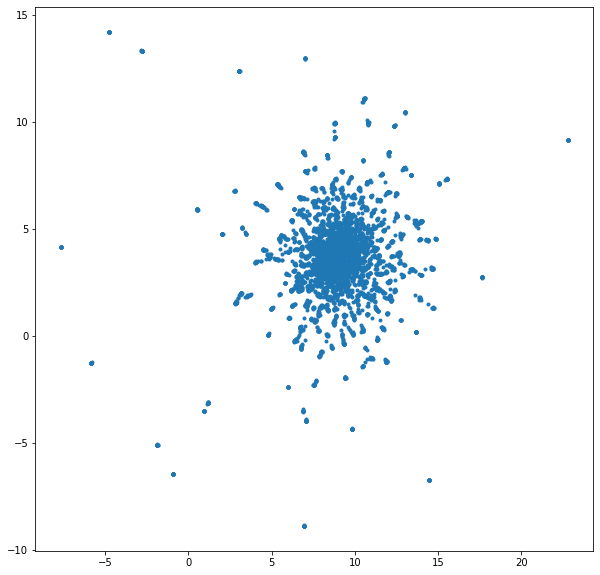

In [127]:
plt.figure(figsize=(10,10))
plt.plot(embedding[:,0], embedding[:,1],'.')
# _ = plt.axis('square')

In [52]:
# Visualize actors in the embeddings space

edit_counts = np.squeeze(np.asarray(np.sum(implicit_matrix[indices,:],axis=1)))
log_edit_counts = np.log10(np.squeeze(np.asarray(np.sum(implicit_matrix[indices,:],axis=1))))

emb_df = pd.DataFrame({'dim1':embedding[:,0].squeeze(), 
                       'dim2':embedding[:,1].squeeze(),
                       'title':[i2t[i] for i in indices],
                       'edit_count':edit_counts,
                       'log_edit_count':log_edit_counts
                       })

actors = ['Mark Hamill',
'Carrie Fisher',
'James Earl Jones',
'David Prowse',
'Sebastian Shaw (actor)',
'Alec Guinness',
'Jake Lloyd',
'Hayden Christensen',
'Ewan McGregor',
'William Shatner',
'Leonard Nimoy',
'DeForest Kelley',
'James Doohan',
'George Takei']
actor_indices = [t2i[a] for a in actors]
edit_counts = np.squeeze(np.asarray(np.sum(implicit_matrix[actor_indices,:],axis=1)))
log_edit_counts = np.log10(np.squeeze(np.asarray(np.sum(implicit_matrix[actor_indices,:],axis=1))))
embedding = umap.UMAP().fit_transform(model.item_factors[actor_indices,:])
emb_df = pd.DataFrame({'dim1':embedding[:,0].squeeze(), 
                       'dim2':embedding[:,1].squeeze(),
                       'title':[i2t[i] for i in actor_indices],
                       'edit_count':edit_counts,
                       'log_edit_count':log_edit_counts
                       })
fig = px.scatter(data_frame=emb_df,
                 x='dim1',
                 y='dim2', 
                 hover_name='title',
                 color='log_edit_count',
                 hover_data=['edit_count'])
fig.update_layout(
    autosize=False,
    width=600,
    height=600,)
fig.show()

In [128]:
# Full embedding plotly interactive visualization

emb_df = pd.DataFrame({'dim1':embedding[:,0].squeeze(), 
                       'dim2':embedding[:,1].squeeze(),
                       'title':[i2t[i] for i in indices],
                       'edit_count':edit_counts,
                       'log_edit_count':log_edit_counts
                       })

fig = px.scatter(data_frame=emb_df,
                 x='dim1',
                 y='dim2', 
                 hover_name='title',
                 color='log_edit_count',
                 hover_data=['edit_count'])
fig.update_layout(
    autosize=False,
    width=600,
    height=600,)
fig.show()

KeyError: 80754

# Evaluate on test set

In [2]:
# Load the edit histories in the training set and the test set
histories_train = wr.load_pickle('../histories_train.pickle')
histories_test = wr.load_pickle('../histories_test.pickle')

implicit_matrix = wr.load_pickle('../implicit_matrix.pickle')
p2t, t2p, u2n, n2u, p2i, u2i, i2p, i2u, n2i, t2i, i2n, i2t = wr.load_pickle('../lookup_tables.pickle')

userids, pageids = wr.load_pickle('users_and_pages.pickle')

                                                                                                  

5628 out of 9485 userids are resurfaced (59.3%)
3857 out of 9485 userids are discovered (40.7%)


In [411]:
wr.display_recs_with_history(
    recs,
    userids[:100],
    histories_test,
    histories_train,
    p2t,
    u2n,
    recs_to_display=5,
    hist_to_display=10,
)

AxelBoldt  \
True value             Ulm Minster   
Rec 1          Girolamo Savonarola   
Rec 2                    CoronaVac   
Rec 3       Blackbird (land yacht)   
Rec 4               Allium ursinum   
Rec 5                Monocotyledon   
-                       ----------   
Hist 1         Girolamo Savonarola   
Hist 2                   CoronaVac   
Hist 3      Blackbird (land yacht)   
Hist 4      Blackbird (land yacht)   
Hist 5              Allium ursinum   
Hist 6               Monocotyledon   
Hist 7       Tumor necrosis factor   
Hist 8       Tumor necrosis factor   
Hist 9                Ernst J√ºnger   
Hist 10                 Empedocles   

                                                  Berek  \
True value                            Exterior calculus   
Rec 1       2020 Bangladesh Election Commission scandal   
Rec 2                                        Kepler-533   
Rec 3           Next Indian general election in Gujarat   
Rec 4                                  Madhava Varma II   
Rec 5          Fairness for High Skilled Immigrants Act   
-                                            ----------   
Hist 1      2020 Bangladesh Election Commission scandal   
Hist 2                                       Kepler-533   
Hist 3                                       Kepler-533   
Hist 4                                       Kepler-533   
Hist 5          Next Indian general election in Gujarat   
Hist 6                                 Madhava Varma II   
Hist 7         Fairness for High Skilled Immigrants Act   
Hist 8                           Eristalinus tabanoides   
Hist 9                           Eristalinus tabanoides   
Hist 10                          Eristalinus tabanoides   

                                                RobLa  \
True value                   Civil Rights Act of 1964   
Rec 1                        Civil Rights Act of 1964   
Rec 2       Student Nonviolent Coordinating Committee   
Rec 3                               Leesburg Stockade   
Rec 4                                      John Lewis   
Rec 5                             West Seattle Bridge   
-                                          ----------   
Hist 1                       Civil Rights Act of 1964   
Hist 2      Student Nonviolent Coordinating Committee   
Hist 3      Student Nonviolent Coordinating Committee   
Hist 4                       Civil Rights Act of 1964   
Hist 5                              Leesburg Stockade   
Hist 6      Student Nonviolent Coordinating Committee   
Hist 7      Student Nonviolent Coordinating Committee   
Hist 8      Student Nonviolent Coordinating Committee   
Hist 9                                     John Lewis   
Hist 10     Student Nonviolent Coordinating Committee   

                                               LA2            Shsilver  \
True value                                    Flax       David Britton   
Rec 1                       Elmer William Engstrom         Jorie Remus   
Rec 2                                   Sidney Low    Leonard B. Stern   
Rec 3                              Living Lutheran   List of Worldcons   
Rec 4                         Esperance Stonehenge           Mata Hari   
Rec 5                                 Alice Tegn√©r    Galgano Guidotti   
-                                       ----------          ----------   
Hist 1                      Elmer William Engstrom         Jorie Remus   
Hist 2                                  Sidney Low         Jorie Remus   
Hist 3                             Living Lutheran    Leonard B. Stern   
Hist 4                        Esperance Stonehenge   List of Worldcons   
Hist 5                                Alice Tegn√©r           Mata Hari   
Hist 6                       Baa, Baa, Black Sheep           Mata Hari   
Hist 7      Top of the World (The Carpenters song)    Galgano Guidotti   
Hist 8                                  Malmf√§lten  Phyllis Eisenstein   
Hist 9                                       Tartu  Phyllis Ei

In [36]:
%%time
K=20
precs = prec.recommend_all(userids, K)
print("Overall popular")
print("Recall @ %d: %.1f%%" % (K, 100*wr.recall(histories_test, precs, K)))
print("nDCG @ %d: %.3f" % (K, wr.ndcg(histories_test, precs, K)))
print("Recall @ %d (discovery): %.1f%%" % (K, 100*wr.recall(histories_test, precs, K, userid_subset=discovery_userids)))
print("Recall @ %d (resurface): %.1f%%" % (K, 100*wr.recall(histories_test, precs, K, userid_subset=resurface_userids)))
print("nDCG @ %d (resurface): %.3f" % (K, wr.ndcg(histories_test, precs, K, userid_subset=resurface_userids)))
print("nDCG @ %d (discovery): %.3f " % (K, wr.ndcg(histories_test, precs, K, userid_subset=discovery_userids)))
print("Prop resurfaced: %.1f%%" % (100*wr.prop_resurface(precs, K, implicit_matrix, i2p, u2i)))


  0%|          | 0/9485 [00:00<?, ?it/s]

Overall popular
Recall @ 20: 0.2%
nDCG @ 20: 0.001
Recall @ 20 (discovery): 0.1%
Recall @ 20 (resurface): 0.2%
nDCG @ 20 (resurface): 0.001
nDCG @ 20 (discovery): 0.001 
Prop resurfaced: 1.1%
CPU times: user 22.8 s, sys: 313 ms, total: 23.1 s
Wall time: 23.3 s


In [37]:
%%time
# Most recent
K=20
rrecs = rrec.recommend_all(userids, K, interactions=histories_train)
print("Most recent")
print("Recall @ %d: %.1f%%" % (K, 100*wr.recall(histories_test, rrecs, K)))
print("nDCG @ %d: %.3f" % (K, wr.ndcg(histories_test, rrecs, K)))
print("Recall @ %d (discovery): %.1f%%" % (K, 100*wr.recall(histories_test, rrecs, K, userid_subset=discovery_userids)))
print("Recall @ %d (resurface): %.1f%%" % (K, 100*wr.recall(histories_test, rrecs, K, userid_subset=resurface_userids)))
print("nDCG @ %d (resurface): %.3f" % (K, wr.ndcg(histories_test, rrecs, K, userid_subset=resurface_userids)))
print("nDCG @ %d (discovery): %.3f " % (K, wr.ndcg(histories_test, rrecs, K, userid_subset=discovery_userids)))
print("Prop resurfaced: %.1f%%" % (100*wr.prop_resurface(rrecs, K, implicit_matrix, i2p, u2i)))


  0%|          | 0/9485 [00:00<?, ?it/s]

Most recent
Recall @ 20: 51.1%
nDCG @ 20: 0.432
Recall @ 20 (discovery): 0.1%
Recall @ 20 (resurface): 86.1%
nDCG @ 20 (resurface): 0.728
nDCG @ 20: 0.000 (discovery)
Prop resurfaced: 82.3%
CPU times: user 2min 20s, sys: 9.61 s, total: 2min 30s
Wall time: 2min 34s


In [44]:
metrics = wr.get_recs_metrics(
    histories_test, frecs, K, discovery_userids, resurface_userids, implicit_matrix, i2p, u2i)


In [45]:
metrics  

{'recall': 37.511860832894044,
 'ndcg': 0.2334107312084989,
 'resurfaced': 82.33948339483396,
 'recall_discover': 0.051853772361939325,
 'recall_resurface': 63.18407960199005,
 'ndcg_discover': 0.00012979221335961656,
 'ndcg_resurface': 0.39328361352979463}

In [38]:
%%time
# Sorted by frequency of edits
K=20
frec = recommenders.MostFrequentRecommender(histories_train)
frecs = frec.recommend_all(userids, K, interactions=histories_train)
print("Most frequent")
print("Recall @ %d: %.1f%%" % (K, 100*wr.recall(histories_test, frecs, K)))
print("nDCG @ %d: %.3f" % (K, wr.ndcg(histories_test, frecs, K)))
print("Recall @ %d (discovery): %.1f%%" % (K, 100*wr.recall(histories_test, frecs, K, userid_subset=discovery_userids)))
print("Recall @ %d (resurface): %.1f%%" % (K, 100*wr.recall(histories_test, frecs, K, userid_subset=resurface_userids)))
print("nDCG @ %d (resurface): %.3f" % (K, wr.ndcg(histories_test, frecs, K, userid_subset=resurface_userids)))
print("nDCG @ %d (discovery): %.3f " % (K, wr.ndcg(histories_test, frecs, K, userid_subset=discovery_userids)))
print("Prop resurfaced: %.1f%%" % (100*wr.prop_resurface(frecs, K, implicit_matrix, i2p, u2i)))


 Entering code segment Building popularity table
 Code segment Building popularity table took 17.3418231010437


  0%|          | 0/9485 [00:00<?, ?it/s]

Most frequent
Recall @ 20: 37.5%
nDCG @ 20: 0.233
Recall @ 20 (discovery): 0.1%
Recall @ 20 (resurface): 63.2%
nDCG @ 20 (resurface): 0.393
nDCG @ 20 (discovery): 0.000 
Prop resurfaced: 82.3%
CPU times: user 2min 37s, sys: 17.7 s, total: 2min 55s
Wall time: 3min 5s


### Implicit collaborative filtering

In [194]:
wr.load_pickle('../implicit_matrix.pickle')

<2024883x9485 sparse matrix of type '<class 'numpy.int32'>'
	with 0 stored elements in Compressed Sparse Column format>

In [76]:
num_factors = 10

In [77]:
model = implicit.als.AlternatingLeastSquares(factors=num_factors, regularization=0.01)

In [108]:
# implicit_matrix[implicit_matrix > 1] = 1

In [78]:
%%time
model.fit(implicit_matrix)


  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 9min 34s, sys: 5min 21s, total: 14min 56s
Wall time: 9min 43s


In [80]:
wr.save_pickle(model,'../als%d_model.pickle' % num_factors)

In [69]:
model = wr.load_pickle('../als100_model.pickle')

In [82]:
%%time
K=20
irec = recommenders.ImplicitCollaborativeRecommender(model, implicit_matrix)
irecs = irec.recommend_all(userids, K, u2i=u2i, n2i=n2i, i2p=i2p)
wr.get_recs_metrics(
    histories_test, irecs, K, discovery_userids, resurface_userids, implicit_matrix, i2p, u2i)

  0%|          | 0/9485 [00:00<?, ?it/s]

CPU times: user 13min 7s, sys: 1min 33s, total: 14min 40s
Wall time: 8min 3s


{'recall': 2.9731154454401687,
 'ndcg': 0.01638851291290074,
 'resurfaced': 4.265155508697944,
 'recall_discover': 0.233341975628727,
 'recall_resurface': 4.850746268656716,
 'ndcg_discover': 0.0011310548078796283,
 'ndcg_resurface': 0.026844805718705005}

In [ ]:
%%time
# Implicit collaborative filtering (ALS)
K=5
irecs = irec.recommend_all(userids, 5, u2i=u2i, n2i=n2i, i2p=i2p)
print("Implicit collaborative filtering")

In [247]:
print("Recall @ %d: %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K)))
print("Recall @ %d (resurface): %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K, userid_subset=resurface_userids)))
print("Recall @ %d (discovery): %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K, userid_subset=discovery_userids)))

Recall @ 5: 1.3%
Recall @ 5 (resurface): 2.1%
Recall @ 5 (discovery): 0.1%


In [258]:
%%time
# Implicit collaborative filtering (ALS)
K=5
irecs = irec.recommend_all(userids, 5, u2i=u2i, n2i=n2i, i2p=i2p)
print("Implicit collaborative filtering")

print("Recall @ %d: %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K)))
print("Recall @ %d (resurface): %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K, userid_subset=resurface_userids)))
print("Recall @ %d (discovery): %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K, userid_subset=discovery_userids)))

  0%|          | 0/11533 [00:00<?, ?it/s]

Implicit collaborative filtering
Recall @ 5: 4.6%
Recall @ 5 (resurface): 7.6%
Recall @ 5 (discovery): 0.2%
CPU times: user 39min, sys: 3min 5s, total: 42min 5s
Wall time: 23min 10s


In [295]:
%%time
# Implicit collaborative filtering (ALS)
K=5
irecs = irec.recommend_all(userids, 5, u2i=u2i, n2i=n2i, i2p=i2p)
print("Implicit collaborative filtering")

print("Recall @ %d: %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K)))
print("Recall @ %d (resurface): %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K, userid_subset=resurface_userids)))
print("Recall @ %d (discovery): %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K, userid_subset=discovery_userids)))

  0%|          | 0/11533 [00:00<?, ?it/s]

Implicit collaborative filtering
Recall @ 5: 5.8%
Recall @ 5 (resurface): 9.6%
Recall @ 5 (discovery): 0.3%
CPU times: user 48min 45s, sys: 3min 38s, total: 52min 23s
Wall time: 33min 9s


In [314]:
%%time
# Implicit collaborative filtering (ALS)
K=5
irecs = irec.recommend_all(userids, 5, u2i=u2i, n2i=n2i, i2p=i2p)
print("Implicit collaborative filtering")

print("Recall @ %d: %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K)))
print("Recall @ %d (resurface): %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K, userid_subset=resurface_userids)))
print("Recall @ %d (discovery): %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K, userid_subset=discovery_userids)))

  0%|          | 0/11533 [00:00<?, ?it/s]

Implicit collaborative filtering
Recall @ 5: 7.2%
Recall @ 5 (resurface): 12.0%
Recall @ 5 (discovery): 0.3%
CPU times: user 1h 17min 27s, sys: 3min 25s, total: 1h 20min 52s
Wall time: 48min 27s


In [113]:
%%time
# Implicit collaborative filtering (ALS)
irec = recommenders.ImplicitCollaborativeRecommender(model, implicit_matrix)
K=5
irecs = irec.recommend_all(userids, 5, u2i=u2i, n2i=n2i, i2p=i2p)

  0%|          | 0/9485 [00:00<?, ?it/s]

CPU times: user 53min 13s, sys: 1min 49s, total: 55min 2s
Wall time: 28min 57s


In [114]:
print("Implicit collaborative filtering")

print("Recall @ %d: %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K)))
print("Recall @ %d (resurface): %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K, userid_subset=resurface_userids)))
print("Recall @ %d (discovery): %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K, userid_subset=discovery_userids)))

Implicit collaborative filtering
Recall @ 5: 8.9%
Recall @ 5 (resurface): 14.7%
Recall @ 5 (discovery): 0.3%


In [147]:
recent_pages_dict = rrec.all_recent_only(50, userids,  interactions=histories_train)


  0%|          | 0/9485 [00:00<?, ?it/s]

In [280]:
%%time
# Sorted by Jaccard
K=5
jrec = recommenders.JaccardRecommender(implicit_matrix, p2i=p2i, t2i=t2i, i2t=i2t, i2p=i2p, n2i=n2i, u2i=u2i, i2u=i2u)
jrecs = jrec.recommend_all(userids, 
                                   10, 
                                   num_lookpage_pages=1, 
                                   recent_pages_dict=recent_pages_dict, 
                                   interactions=histories_train)
print("Jaccard")

  0%|          | 0/9485 [00:00<?, ?it/s]

/Users/dsaunder/WikiRecs/repo/recommenders.py:212: RuntimeWarning:

Mean of empty slice

/Users/dsaunder/WikiRecs/venvs/wikirecs/lib/python3.8/site-packages/scipy/sparse/base.py:595: RuntimeWarning:

invalid value encountered in true_divide



Jaccard
CPU times: user 53min 49s, sys: 8min 9s, total: 1h 1min 59s
Wall time: 1h 2min 46s


In [278]:
wr.display_recs_with_history(
    jrecs,
    userids[:30],
    histories_test,
    histories_train,
    p2t,
    u2n,
    recs_to_display=5,
    hist_to_display=10,
)

AxelBoldt  \
True value             Ulm Minster   
Rec 1            Passiflora edulis   
Rec 2            Rubus chamaemorus   
Rec 3         Hippophae rhamnoides   
Rec 4                  Horseradish   
Rec 5              Capsicum annuum   
-                       ----------   
Hist 1         Girolamo Savonarola   
Hist 2                   CoronaVac   
Hist 3      Blackbird (land yacht)   
Hist 4      Blackbird (land yacht)   
Hist 5              Allium ursinum   
Hist 6               Monocotyledon   
Hist 7       Tumor necrosis factor   
Hist 8       Tumor necrosis factor   
Hist 9                Ernst J√ºnger   
Hist 10                 Empedocles   

                                                  Berek  \
True value                            Exterior calculus   
Rec 1                                  Fishing in India   
Rec 2                             Adam Nash (executive)   
Rec 3                                            RSSOwl   
Rec 4                      Andrew Douglas (rugby union)   
Rec 5                                Broken Hill Mosque   
-                                            ----------   
Hist 1      2020 Bangladesh Election Commission scandal   
Hist 2                                       Kepler-533   
Hist 3                                       Kepler-533   
Hist 4                                       Kepler-533   
Hist 5          Next Indian general election in Gujarat   
Hist 6                                 Madhava Varma II   
Hist 7         Fairness for High Skilled Immigrants Act   
Hist 8                           Eristalinus tabanoides   
Hist 9                           Eristalinus tabanoides   
Hist 10                          Eristalinus tabanoides   

                                                RobLa  \
True value                   Civil Rights Act of 1964   
Rec 1                             Long Branch station   
Rec 2                                Demarest station   
Rec 3                                Denville station   
Rec 4                             East Orange station   
Rec 5                     Orange station (NJ Transit)   
-                                          ----------   
Hist 1                       Civil Rights Act of 1964   
Hist 2      Student Nonviolent Coordinating Committee   
Hist 3      Student Nonviolent Coordinating Committee   
Hist 4                       Civil Rights Act of 1964   
Hist 5                              Leesburg Stockade   
Hist 6      Student Nonviolent Coordinating Committee   
Hist 7      Student Nonviolent Coordinating Committee   
Hist 8      Student Nonviolent Coordinating Committee   
Hist 9                                     John Lewis   
Hist 10     Student Nonviolent Coordinating Committee   

                                               LA2  \
True value                                    Flax   
Rec 1                           St Georges Terrace   
Rec 2                    Neil McNeil (businessman)   
Rec 3                   Subiaco, Western Australia   
Rec 4                                   James Peet   
Rec 5                           Court Hotel, Perth   
-                                       ----------   
Hist 1                      Elmer William Engstrom   
Hist 2                                  Sidney Low   
Hist 3                             Living Lutheran   
Hist 4                        Esperance Stonehenge   
Hist 5                                Alice Tegn√©r   
Hist 6                       Baa, Baa, Black Sheep   
Hist 7      Top of the World (The Carpenters song)   
Hist 8                                  Malmf√§lten   
Hist 9                                       Tartu   
Hist 10                           Youth for Christ   

                                       Shsilver  \
True value                        David Britton   
Rec 1       Northeast New York PGA Championship   
Rec 2                     Lasse Jensen (golfer)   
Rec 3                               Mike Donald   
Rec 4              

In [266]:
%%time
# Sorted by Jaccard
K=5
jrec = recommenders.JaccardRecommender(implicit_matrix, p2i=p2i, t2i=t2i, i2t=i2t, i2p=i2p, n2i=n2i, u2i=u2i, i2u=i2u)
jrecs = jrec.recommend_all(userids[:1000], 
                                   10, 
                                   num_lookpage_pages=50, 
                                   recent_pages_dict=recent_pages_dict, 
                                   interactions=histories_train)
print("Jaccard")

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/dsaunder/WikiRecs/repo/recommenders.py:212: RuntimeWarning:

Mean of empty slice



Jaccard
CPU times: user 51min 21s, sys: 38min 14s, total: 1h 29min 36s
Wall time: 1h 35min 25s


In [279]:
K=5
print("Recall @ %d: %.2f%%" % (K, 100*wr.recall(histories_test, jrecs, K)))
print("Prop resurfaced: %.2f%%" % (100*wr.prop_resurface(jrecs, K, implicit_matrix, i2p, u2i)))
print("Recall @ %d (discovery): %.2f%%" % (K, 100*wr.recall(histories_test, jrecs, K, userid_subset=discovery_userids)))
print("Recall @ %d (resurface): %.2f%%" % (K, 100*wr.recall(histories_test, jrecs, K, userid_subset=resurface_userids)))

Recall @ 5: 0.30%
Prop resurfaced: 3.16%
Recall @ 5 (discovery): 0.21%
Recall @ 5 (resurface): 0.39%


In [281]:
K=5
print("Recall @ %d: %.2f%%" % (K, 100*wr.recall(histories_test, jrecs, K)))
print("Prop resurfaced: %.2f%%" % (100*wr.prop_resurface(jrecs, K, implicit_matrix, i2p, u2i)))
print("Recall @ %d (discovery): %.2f%%" % (K, 100*wr.recall(histories_test, jrecs, K, userid_subset=discovery_userids)))
print("Recall @ %d (resurface): %.2f%%" % (K, 100*wr.recall(histories_test, jrecs, K, userid_subset=resurface_userids)))

Recall @ 5: 23.10%
Prop resurfaced: 14.73%
Recall @ 5 (discovery): 0.57%
Recall @ 5 (resurface): 38.54%


In [276]:
K=5
print("Recall @ %d: %.2f%%" % (K, 100*wr.recall(histories_test, jrecs, K)))
print("Prop resurfaced: %.2f%%" % (100*wr.prop_resurface(jrecs, K, implicit_matrix, i2p, u2i)))
print("Recall @ %d (discovery): %.2f%%" % (K, 100*wr.recall(histories_test, jrecs, K, userid_subset=discovery_userids)))
print("Recall @ %d (resurface): %.2f%%" % (K, 100*wr.recall(histories_test, jrecs, K, userid_subset=resurface_userids)))

Recall @ 5: 17.60%
Prop resurfaced: 12.58%
Recall @ 5 (discovery): 0.42%
Recall @ 5 (resurface): 33.53%


In [270]:
K=5
print("Recall @ %d: %.2f%%" % (K, 100*wr.recall(histories_test, jrecs, K)))
print("Prop resurfaced: %.2f%%" % (100*wr.prop_resurface(jrecs, K, implicit_matrix, i2p, u2i)))
print("Recall @ %d (discovery): %.2f%%" % (K, 100*wr.recall(histories_test, jrecs, K, userid_subset=discovery_userids)))
print("Recall @ %d (resurface): %.2f%%" % (K, 100*wr.recall(histories_test, jrecs, K, userid_subset=resurface_userids)))

Recall @ 5: 0.30%
Prop resurfaced: 5.82%
Recall @ 5 (discovery): 0.00%
Recall @ 5 (resurface): 0.58%


In [150]:
print("Recall @ %d: %.1f%%" % (K, 100*wr.recall(histories_test, jrecs, K)))
print("Prop resurfaced: %.1f%%" % (100*wr.prop_resurface(jrecs, K, implicit_matrix, i2p, u2i)))
print("Recall @ %d (discovery): %.1f%%" % (K, 100*wr.recall(histories_test, jrecs, K, userid_subset=discovery_userids)))
print("Recall @ %d (resurface): %.1f%%" % (K, 100*wr.recall(histories_test, jrecs, K, userid_subset=resurface_userids)))

Recall @ 5: 0.0%
Prop resurfaced: 22.0%
Recall @ 5 (discovery): 0.0%
Recall @ 5 (resurface): 0.0%


# Jaccard recommender development

In [ ]:
implicit_matrix = wr.load_pickle('../implicit_matrix.pickle')
p2t, t2p, u2n, n2u, p2i, u2i, i2p, i2u, n2i, t2i, i2n, i2t = wr.load_pickle('../lookup_tables.pickle')

In [122]:
jrec = recommenders.JaccardRecommender(implicit_matrix, p2i=p2i, t2i=t2i, i2t=i2t, i2p=i2p, n2i=n2i, u2i=u2i, i2u=i2u)

In [119]:
%%time
for title in 100*['Batman','Titanic','An American Tail','Batman Begins','Batman Forever']:
    jrec.item_to_item(N=10, title=title)

CPU times: user 53.5 s, sys: 6.53 s, total: 1min
Wall time: 1min 2s


In [86]:
user_name = 'DoctorWho42'

user_page_indices = np.flatnonzero(implicit_matrix[:,n2i[user_name]].A)

In [ ]:
%%time
for title in tqdm([i2t[i] for i in user_page_indices], total=len(user_page_indices)):
    jrec.item_to_item(N=10, title=title)

In [133]:
my_indices = [i2t[i] for i in user_page_indices]

In [98]:
%%time
d = jrec.jaccard_multiple(user_page_indices[:100], exclude_index=n2i[user_name])

(2025959, 9484)
(9484, 100)
CPU times: user 5.01 s, sys: 5.45 s, total: 10.5 s
Wall time: 11.6 s


In [22]:
# d[d == 1] = np.nan

# d[d == 1] = 0

In [102]:
mean_jaccard = np.nanmean(d,axis=1).A.squeeze()

order = np.argsort(mean_jaccard)[::-1]

In [124]:
%%time
jrecs = jrec.recommend(N=10, 
                       user=user_name, 
                       num_lookpage_pages=50, 
                       recent_pages_dict=rrecs, 
                       interactions=histories_train)

(2025959, 9484)
(9484, 50)


/Users/dsaunder/WikiRecs/venvs/wikirecs/lib/python3.8/site-packages/scipy/sparse/base.py:595: RuntimeWarning:

invalid value encountered in true_divide



CPU times: user 3.63 s, sys: 3.11 s, total: 6.73 s
Wall time: 7.77 s


In [129]:
wr.prop_resurface(jrecs, K=10, implicit_matrix=implicit_matrix, i2p=i2p, u2i=u2i)

AttributeError: 'list' object has no attribute 'keys'

In [372]:
%%time
user_name = "DoctorWho42"
recent_pages = rrec.recommend(N=50,user=user_name, interactions=histories_train)
user_page_indices = [p2i[p] for p in recent_pages]
d = jrec.jaccard_multiple(user_page_indices, exclude_index=n2i[user_name])

CPU times: user 3.29 s, sys: 3.18 s, total: 6.47 s
Wall time: 8.97 s


In [323]:
recs = jrec.recommend(N=10,user='DoctorWho42', num_lookpage_pages=50, recent_pages_dict=recent_pages_dict, interactions=histories_train)

/Users/dsaunder/WikiRecs/venvs/wikirecs/lib/python3.8/site-packages/scipy/sparse/base.py:595: RuntimeWarning:

invalid value encountered in true_divide



In [265]:
[p2t[r] for r in recs]

['Let Them All Talk (film)',
 'One Night in Miami (film)',
 'StepMania',
 'Hillbilly Elegy (film)',
 'Maude Apatow',
 'Holder baronets',
 'Davis baronets',
 "King Leopold's Soliloquy",
 'Amy Seimetz',
 'The Glorias']

In [373]:
f = np.array(d)

# f = np.nan_to_num(f)

f[f==1] = np.nan
f[f==0] = np.nan


In [374]:
m = np.nanmean(f,axis=0)
s = np.nanstd(f,axis=0)

f = f-m

f = f/s

<ipython-input-374-f2180cd56fa5>:1: RuntimeWarning:

Mean of empty slice



In [375]:
mean_jaccard = np.nanmax(f,axis=1).squeeze()
mean_jaccard = np.nan_to_num(mean_jaccard)
order = np.argsort(mean_jaccard)[::-1]

<ipython-input-375-191362fdf93b>:1: RuntimeWarning:

All-NaN slice encountered



In [376]:
[p2t[p] for p in recent_pages[np.argmax(np.nan_to_num(f),axis=1)[order][:50]]]

['The Owl House',
 'The Owl House',
 'Tenet (film)',
 'Tenet (film)',
 'Tenet (film)',
 'Tenet (film)',
 'Tenet (film)',
 'Star Trek',
 'The Owl House',
 'Tenet (film)',
 'Tenet (film)',
 'The Owl House',
 'The Owl House',
 'Tenet (film)',
 'The Owl House',
 'Tenet (film)',
 'Tenet (film)',
 'Tenet (film)',
 'Tenet (film)',
 'The Owl House',
 'Tenet (film)',
 'Tenet (film)',
 'Tenet (film)',
 'Tenet (film)',
 'Tenet (film)',
 'Tenet (film)',
 'Tenet (film)',
 'Tenet (film)',
 'Tenet (film)',
 'The Prom (film)',
 'Tenet (film)',
 'Tenet (film)',
 'Tenet (film)',
 'The Owl House',
 'The Prom (film)',
 'The Owl House',
 'Tenet (film)',
 'Tenet (film)',
 'Tenet (film)',
 'Tenet (film)',
 'The Owl House',
 'The Owl House',
 'The Owl House',
 'The Owl House',
 'The Owl House',
 'Tenet (film)',
 'Tenet (film)',
 'The Mummy (1999 film)',
 'Tenet (film)',
 'Tenet (film)']

In [377]:
[(i2t[o], mean_jaccard[o]) for o in order[:50] if o in i2t]

[('Amphibia (TV series)', 34.0328591085672),
 ('List of DuckTales (2017 TV series) episodes', 22.75112887455014),
 ('Wonder Woman 1984', 22.603945620210737),
 ('The Batman (film)', 21.722867031915193),
 ('The New Mutants (film)', 21.387134716953938),
 ('The Invisible Man (2020 film)', 20.409561211625594),
 ('Mulan (2020 film)', 20.090948556999127),
 ('List of Star Trek films and television series', 19.107873303565135),
 ('Big City Greens', 18.873640773011182),
 ('The Suicide Squad (film)', 18.83828460520769),
 ('A Quiet Place Part II', 18.551109579140324),
 ('Mao Mao: Heroes of Pure Heart', 18.424132806577056),
 ('List of Big City Greens episodes', 18.424132806577056),
 ('Once Upon a Time in Hollywood', 18.40730807577425),
 ('ThunderCats Roar', 18.25629703988899),
 ('Mank', 18.172077221502583),
 ('Sonic the Hedgehog (film)', 18.138314675360068),
 ('1917 (2019 film)', 17.743746412231797),
 ('No Time to Die', 17.598113937079724),
 ('The Casagrandes', 17.580158665517068),
 ('Birds of Prey

In [208]:
order = np.argsort(f[:,j])[::-1]

In [253]:
wr.print_user_history(histories_train, user='Da Vynci')

2020-04-11
 16:19:45 Lalo Salamanca
 20:33:34 Remdesivir
2020-05-17
 03:56:51 Epic Games
2020-05-19
 08:03:05 Snoop (The Wire)
2020-05-20
 08:16:36 Snoop (The Wire)
2020-06-01
 03:36:08 Jackie Chan
 08:56:32 British National (Overseas)
2020-06-04
 12:48:33 Hong Kong national security law
2020-07-18
 05:01:07 Arthur M. Ratliff
2020-07-22
 09:08:18 Franz Reichelt
2020-07-28
 04:59:43 Sam Worthington
2020-08-01
 03:16:29 Barksdale Organization
 05:39:20 Sh≈çjo
2020-08-03
 04:09:24 Principality of Hutt River
2020-08-08
 04:38:08 Maurice Levy (The Wire)
2020-08-19
 17:17:28 Ch≈´ichi Nagumo
2020-08-20
 23:10:32 Prince of Wales Hospital
 23:40:52 Queen Mary Hospital (Hong Kong)
 23:46:55 Prince of Wales Hospital
2020-08-21
 13:04:08 James Cantlie
2020-08-22
 17:11:20 History of Hong Kong (1800s‚Äì1930s)
2020-08-25
 16:40:48 ≈åtani Yoshitsugu
2020-08-26
 20:18:28 History of Hong Kong (1800s‚Äì1930s)
 20:26:23 Maurice Levy (The Wire)
2020-09-04
 04:02:33 Maurice Levy (The Wire)
2020-09-07
 06:4

In [197]:
order

array([2025958,  675309,  675311, ..., 1350644, 1350645,       0])

In [198]:
for j in range(50):
    p = recent_pages[j]
    print(p2t[p])
    order = np.argsort(f[:,j])[::-1]
    for o in order[:10]:
        print("   {} ({})".format(i2t[o],f[o,j]))

Jo Ellen Pellman
   Jo Ellen Pellman (1.0)
   Monique Coleman (0.3333333333333333)
   Erin Yvette (0.3333333333333333)
   Susie Essman (0.2857142857142857)
   Michael Hogan (Canadian actor) (0.25)
   P. J. Byrne (0.25)
   Neal Bledsoe (0.2222222222222222)
   Enver Gjokaj (0.2222222222222222)
   Matilda (novel) (0.2222222222222222)
   Plainfield North High School (0.2)
Steven Universe
   Steven Universe (1.0)
   Steven Universe Future (0.21052631578947367)
   Infinity Train (0.20689655172413793)
   OK K.O.! Let's Be Heroes (0.2)
   List of Steven Universe episodes (0.2)
   Adventure Time: Distant Lands (0.19230769230769232)
   Tangled: Before Ever After (0.1875)
   She-Ra and the Princesses of Power (0.17857142857142858)
   Elliott from Earth (0.17647058823529413)
   Steven Universe: The Movie (0.17647058823529413)
Busy Philipps
   Busy Philipps (1.0)
   Linda Blair (0.1875)
   Brothers (disambiguation) (0.18181818181818182)
   Andrew Feinberg (0.18181818181818182)
   Brother Martin Hig

   Crellius (1.0)
   Henry Coventry (deist) (1.0)
   Holbourn (1.0)
   Charles Rogers (author) (1.0)
   Thomas Wilson (1.0)
   Philip Metcalfe (1.0)
   Charles Rogers (minister) (1.0)
   Lord George Beauclerk (1.0)
   Absalom Watkin (1.0)
   William Robert Hay (1.0)
Compton Bay
   Tornado Outbreak of December 23-24 2020 (0.0)
   Barrie Rutter (0.0)
   Gardner Airport (0.0)
   List of towns and cities with 100,000 or more inhabitants/cityname: B (0.0)
   Kesklinn, Tallinn (0.0)
   List of towns and cities with 100,000 or more inhabitants/cityname: C (0.0)
   P√µhja-Tallinn (0.0)
   Muhammad Aslam Khan Raisani (0.0)
   Aldama (surname) (0.0)
   √âder Lu√≠s (0.0)
Feminization (activity)
   Feminization (activity) (1.0)
   East Canton, Ohio (0.5)
   Felix Weir (0.5)
   Volo (Company) (0.5)
   Dukhan Field (0.5)
   Re:Zero -Starting Life in Another World- Lost in Memories (0.5)
   Miller process (0.5)
   Demon: The Fallen (0.5)
   Adriana Kaegi (0.5)
   Werewolf: The Apocalypse (0.5)
Adapta

   Two Fat Ladies (1.0)
   National Movement of Hope (0.3333333333333333)
   32nd Street, Yangon (0.3333333333333333)
   Egyptian Patriotic Movement (0.3333333333333333)
   Conus abruptus (0.3333333333333333)
   Antiimperialist Action Front ‚Äì Suxxali Reew Mi (0.3333333333333333)
   Round One: The Album (0.3333333333333333)
   Movement for Youth and Democracy (0.3333333333333333)
   National Party for Solidarity and Development (0.3333333333333333)
   National Movement for Nature and Development (0.3333333333333333)
Stars (Canadian band)
   Silversun Pickups (1.0)
   Tigers Jaw (1.0)
   Vertical Horizon (1.0)
   Stars (Canadian band) (1.0)
   Something for Kate (0.6666666666666666)
   The Church (band) (0.6666666666666666)
   Gossip (band) (0.6666666666666666)
   Sarah Jones (drummer) (0.6666666666666666)
   Black Box Distribution (0.5)
   EthosCE (0.5)
There Is a Song
   Tornado Outbreak of December 23-24 2020 (0.0)
   Barrie Rutter (0.0)
   Gardner Airport (0.0)
   List of towns and

In [171]:
np.argsort(d,axis=0)

matrix([[      0,       0,       0, ...,       0,       0,       0],
        [1349548, 1347429, 1347875, ..., 1350196, 1350149, 1350525],
        [1349547, 1347428, 1347874, ..., 1350195, 1350148, 1350524],
        ...,
        [1466731, 1495657,  224153, ..., 1445142,   57708,  232946],
        [ 447930, 1700016,  100702, ...,  748938, 1119610,  232733],
        [1994315, 1235794,  248562, ...,  329746,  548154, 2025958]])

In [163]:
[(i2t[o], mean_jaccard[o]) for o in order if o in i2t]

[('The Prom (film)', 0.03801203770359515),
 ('The Father (2020 film)', 0.03460194809571696),
 ('Promising Young Woman', 0.03351294242348335),
 ('Amanda Seyfried', 0.03137488850168366),
 ('Tenet (film)', 0.029551114760624508),
 ('The Prom (musical)', 0.02828571428571429),
 ('The Owl House', 0.02705040353419406),
 ('Steven Universe', 0.026728534813758524),
 ('Maria Bamford', 0.025640510366826158),
 ('Tron: Legacy', 0.025178777176219632),
 ('List of pansexual people', 0.025),
 ('List of bisexual people (A‚ÄìF)', 0.025),
 ('Jo Ellen Pellman', 0.02411111111111111),
 ('Busy Philipps', 0.02313548387096774),
 ('Let Them All Talk (film)', 0.023122178625985423),
 ('The Mummy (1999 film)', 0.022496421111996404),
 ('Tron', 0.022287581699346404),
 ('Star Trek', 0.021970732970732973),
 ('One Night in Miami (film)', 0.02171744515350433),
 ('StepMania', 0.021666666666666664),
 ('Cross-dressing in film and television', 0.021507177033492822),
 ('Tron (franchise)', 0.02138699690402477),
 ('Glenn Close', 

In [155]:
[(i2t[o], mean_jaccard[o]) for o in order if o in i2t]

[('The Prom (film)', 0.03801203770359515),
 ('The Father (2020 film)', 0.03460194809571696),
 ('Promising Young Woman', 0.03351294242348335),
 ('Amanda Seyfried', 0.03137488850168366),
 ('Tenet (film)', 0.029551114760624508),
 ('The Prom (musical)', 0.02828571428571429),
 ('The Owl House', 0.02705040353419406),
 ('Steven Universe', 0.026728534813758524),
 ('Maria Bamford', 0.025640510366826158),
 ('Tron: Legacy', 0.025178777176219632),
 ('List of pansexual people', 0.025),
 ('List of bisexual people (A‚ÄìF)', 0.025),
 ('Jo Ellen Pellman', 0.02411111111111111),
 ('Busy Philipps', 0.02313548387096774),
 ('Let Them All Talk (film)', 0.023122178625985423),
 ('The Mummy (1999 film)', 0.022496421111996404),
 ('Tron', 0.022287581699346404),
 ('Star Trek', 0.021970732970732973),
 ('One Night in Miami (film)', 0.02171744515350433),
 ('StepMania', 0.021666666666666664),
 ('Cross-dressing in film and television', 0.021507177033492822),
 ('Tron (franchise)', 0.02138699690402477),
 ('Glenn Close', 

In [259]:
px.line(y=mean_jaccard[order][:5000], hover_name=[i2t[o] for o in order[:5000]])

In [29]:
[(i2t[o], mean_jaccard[o]) for o in order if o in i2t]

[('Soft Power (musical)', 0.019938867935625694),
 ('Lauren Patten', 0.01930863581310648),
 ('The Prom (film)', 0.018972157904459632),
 ('Moby-Dick (2019 musical)', 0.018201669088531915),
 ('The Father (2020 film)', 0.017151269392572836),
 ('Ally Maki', 0.017139421670756633),
 ('Brookwell McNamara Entertainment', 0.01604225441071203),
 ('Wadjda', 0.01604225441071203),
 ('Robert Burks', 0.01604225441071203),
 ('Happiest Season (film)', 0.01604225441071203),
 ('Golden Globe Award for Best Supporting Actor ‚Äì Series, Miniseries or Television Film',
  0.01604225441071203),
 ('Benjamin Lavernhe', 0.01604225441071203),
 ('Tony Award for Best Revival of a Play', 0.01604225441071203),
 ('Rebecca Howe', 0.01604225441071203),
 ('Stephen Moyer', 0.01604225441071203),
 ('Wallace Wolodarsky', 0.01604225441071203),
 ('Oslo (play)', 0.01604225441071203),
 ('Standing Up, Falling Down', 0.01604225441071203),
 ('Tobias Zilliacus', 0.01604225441071203),
 ('Timothy Busfield', 0.01604225441071203),
 ('Lenn

In [94]:
jrec.item_to_item(10, 'Leonard Nimoy')

[('Leonard Nimoy', 1.0, 12, 12),
 ('RJ Mitte', 0.21428571428571427, 3, 5),
 ('Buddy Hackett', 0.2, 3, 6),
 ('Sharon Tate', 0.1875, 3, 7),
 ('Katie Telford', 0.16666666666666666, 2, 2),
 ('Presidential reorganization authority', 0.16666666666666666, 2, 2),
 ('Pavel Chekov', 0.16666666666666666, 2, 2),
 ('Lobby', 0.16666666666666666, 2, 2),
 ('Russell Hornsby', 0.16666666666666666, 2, 2),
 ('Glynis Johns', 0.15789473684210525, 3, 10)]

In [67]:
type(implicit_matrix)

scipy.sparse.csc.csc_matrix

In [66]:
implicit_matrix.shape

(2025959, 9485)

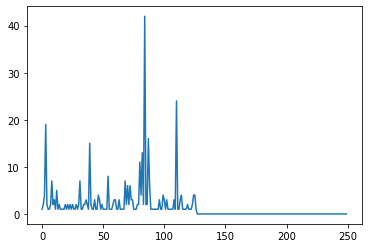

In [258]:
plt.plot(implicit_matrix[order, n2i['DoctorWho42']].A.squeeze()[:250])

In [119]:
jrec.item_to_item(30,'Elton John')

[('Elton John', 1.0, 32, 32),
 ('John Goodman', 0.12195121951219512, 5, 14),
 ('Mick Jagger', 0.12, 6, 24),
 ('Kate Winslet', 0.11904761904761904, 5, 15),
 ('Brad Pitt', 0.11764705882352941, 6, 25),
 ('Madonna', 0.1111111111111111, 6, 28),
 ("List of The Emperor's New Groove characters", 0.10526315789473684, 4, 10),
 ('Alejandro Gonz√°lez I√±√°rritu', 0.10526315789473684, 4, 10),
 ('Elia Kazan', 0.10256410256410256, 4, 11),
 ('Natalie Portman', 0.10204081632653061, 5, 22),
 ('Purple Rain (album)', 0.1, 4, 12),
 ('Robin Williams', 0.0963855421686747, 8, 59),
 ('Alec Baldwin', 0.09433962264150944, 5, 26),
 ('Willem Dafoe', 0.09302325581395349, 4, 15),
 ('Viola Davis', 0.09302325581395349, 4, 15),
 ('Steve Jobs', 0.09259259259259259, 5, 27),
 ('Yeah! (Usher song)', 0.09090909090909091, 3, 4),
 ('Anna Kendrick', 0.09090909090909091, 4, 16),
 ('Samuel L. Jackson', 0.09090909090909091, 4, 16),
 ('Bob Martin (comedian)', 0.09090909090909091, 3, 4),
 ('Ed Sheeran', 0.09090909090909091, 5, 28),

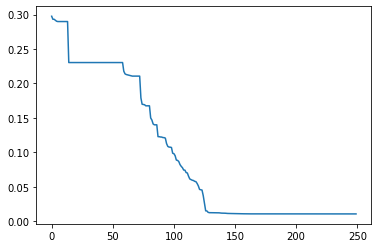

In [263]:
plt.plot(mean_jaccard[order][:250])

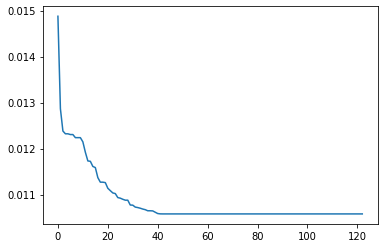

In [264]:
plt.plot(mean_jaccard[order][127:250])

In [249]:
[(i2t[o], mean_jaccard[o]) for o in order if o in i2t]

[('Tony Yazbeck', 0.2952455110941978),
 ('Jeanine Tesori', 0.29089178740684535),
 ('On the Table', 0.2908917874068453),
 ('Erotic hypnosis', 0.28941120324909586),
 ('Francis Jue', 0.2880714162690271),
 ('The Sword of Shannara', 0.28761094751183225),
 ('List of Latinos in film', 0.28761094751183225),
 ('Kyozan Joshu Sasaki', 0.28761094751183225),
 ('James Esdaile', 0.28761094751183225),
 ('Molekule', 0.28761094751183225),
 ('Lego Batman', 0.28761094751183225),
 ('Storefront Hitchcock', 0.28761094751183225),
 ('The Jaunt', 0.28761094751183225),
 ('The Last Detail', 0.28761094751183225),
 ('Dave Malloy', 0.21608518529562856),
 ('David Henry Hwang', 0.21228763367379183),
 ('Stars (Canadian band)', 0.2113045328771809),
 ('List of pansexual people', 0.21084406411998605),
 ('Net Promoter', 0.21027226059542664),
 ('Race Against the Machine', 0.2097822650266909),
 ('Michael Riedel (journalist)', 0.20946726253597353),
 ('The Indian in the Cupboard (film)', 0.20900679377877873),
 ('List of comedy

In [156]:
user_page_indices

array([   6361,    8069,    8315,   11809,   13442,   17930,   51388,
         52288,   54277,   54966,   60100,   66555,   67908,   77237,
         78813,   88293,   97043,  101949,  109381,  118880,  136563,
        139309,  139365,  144108,  158109,  167473,  188003,  192713,
        220359,  237294,  244016,  246514,  248562,  251971,  255191,
        261059,  275180,  306340,  315233,  315461,  327071,  329746,
        345788,  354342,  360268,  370642,  376146,  379752,  385410,
        395093,  413330,  415300,  434673,  436819,  445245,  447351,
        457049,  457820,  464273,  472559,  476229,  512767,  518222,
        521908,  571140,  587771,  595743,  602466,  612105,  654082,
        665283,  668159,  668613,  681426,  681498,  776678,  776679,
        776680,  777544,  808680,  831050,  923524,  936711,  975542,
        985353,  997062, 1009966, 1069713, 1090246, 1157046, 1164109,
       1164342, 1177398, 1180259, 1207578, 1235794, 1301158, 1311003,
       1324953, 1327

In [218]:
implicit_matrix_toy = np.array([[1, 1, 1, 1], [1, 1, 0, 0], [0, 0, 1, 0]])
assert implicit_matrix_toy.shape == (3, 4)
implicit_matrix_toy = csc_matrix(implicit_matrix_toy)
n2it = {"huey": 0, "dewey": 1, "louie": 2, "chewy": 3}
t2it = {"Batman": 0, "Mystery Men": 1, "Taxi Driver": 2}
i2nt = {v: k for k, v in n2it.items()}
i2tt = {v: k for k, v in t2it.items()}

In [219]:
jrec_toy = JaccardRecommender(implicit_matrix_toy, p2i=None, t2i=t2it, i2t=i2tt, i2p=None)


In [232]:
d = jrec_toy.jaccard_multiple([0,1])

In [233]:
mean_jaccard = np.mean(d,axis=1).A.squeeze()
print(mean_jaccard)
order = np.argsort(mean_jaccard)[::-1]
print(order)

[0.75  0.75  0.125]
[1 0 2]


In [236]:
d2 = d.copy()
d2[d2==1] = 0
print(d2)
mean_jaccard = np.nanmean(d2,axis=1).A.squeeze()
print(mean_jaccard)
order = np.argsort(mean_jaccard)[::-1]
print(order)

[[0.   0.5 ]
 [0.5  0.  ]
 [0.25 0.  ]]
[0.25  0.25  0.125]
[1 0 2]


In [237]:
d2 = d.copy()
d2[d2==1] = np.nan
print(d2)
mean_jaccard = np.nanmean(d2,axis=1).A.squeeze()
print(mean_jaccard)
order = np.argsort(mean_jaccard)[::-1]
print(order)

[[ nan 0.5 ]
 [0.5   nan]
 [0.25 0.  ]]
[0.5   0.5   0.125]
[1 0 2]


# Find interesting users

In [8]:
edited_pages = clean_histories.drop_duplicates(subset=['title','user']).groupby('user').userid.count()

edited_pages = edited_pages[edited_pages > 50]
edited_pages = edited_pages[edited_pages < 300]


In [63]:
index = list(range(len(edited_pages)))
np.random.shuffle(index)

for i in index[:10]:
    print(edited_pages.index[i])
    wr.print_user_history(user=edited_pages.index[i],all_histories=clean_histories)
    print("\n\n\n")

Ostalocutanje
2020-01-11
 12:32:48 Serbian comics
2020-02-05
 17:46:54 Serbian comics
2020-02-09
 23:12:17 The Thread of Art
 23:13:30 Technotise
 23:15:03 The Third Argument
2020-02-10
 21:12:42 Zigomar
 21:37:10 Ninja (comic book)
 21:56:22 Master of Death
 22:17:01 Ninja (comic book)
2020-02-11
 12:52:41 Il Grande Blek
 12:55:20 Ninja (comic book)
 12:58:55 Zigomar
 16:59:03 Ninja (comic book)
 17:00:13 Cat Claw
 17:01:47 Dikan
 17:03:05 Kobra (comic book)
 17:03:35 Master of Death
 17:33:57 The Thread of Art
2020-02-17
 11:32:01 D≈æuboks
 14:55:32 Ninja (comic book)
 14:59:57 Modra lasta
 15:11:21 Zigomar
 17:27:56 Gitarijada (Belgrade)
 17:56:04 D≈æuboks
 18:11:59 Gitarijada (Belgrade)
2020-02-19
 01:43:22 Yugoslav science fiction
 13:53:46 Dragutin Iliƒá
 13:54:48 Milutin Milankoviƒá
 13:56:02 Stanislav Vinaver
 13:56:34 Erih Ko≈°
 13:57:08 ƒåedo Vukoviƒá
 13:57:45 Dobrica ƒÜosiƒá
 13:58:11 Politikin Zabavnik
 13:58:44 Galaksija (magazine)
 13:59:40 Deƒçje novine
 14:00:28 Hrvoje

 18:42:42 Vicente Guerrero
 18:49:41 Irish slaves myth
 18:56:56 Vicente Guerrero
 23:43:14 Racism in North America
 23:48:50 Xoloitzcuintle
2020-11-10
 03:01:50 Vicente Guerrero
 03:19:23 Racism in North America
2020-11-11
 14:10:03 Irish slaves myth
 17:04:26 Ryder Ripps
 22:43:23 Slavery in Ireland
2020-11-12
 17:24:19 Irish slaves myth
2020-11-13
 14:30:54 Simone Leigh
 22:04:52 Shibboleth
2020-11-14
 14:30:13 Burren College of Art
 14:31:51 Galway-Mayo Institute of Technology
 14:32:54 Cork Institute of Technology
 14:34:16 Burren College of Art
2020-11-15
 14:06:38 Shibboleth
2020-11-18
 00:04:17 Burren College of Art
2020-11-20
 21:49:00 Project Arts Centre
 21:49:57 Temple Bar Gallery and Studios
 21:50:18 Project Arts Centre
 21:51:14 City Arts Centre, Dublin
 21:52:28 Project Arts Centre
 21:53:08 Ormston House
 21:53:52 Jim Ricks
 22:01:58 Temple Bar Gallery and Studios
 22:05:17 Ormston House
 22:14:13 Burren College of Art
2020-11-22
 03:40:40 Transmission Gallery
 04:03:4

2019-12-30
 11:04:54 The App
2019-12-31
 00:02:49 SpaceX
2020-01-04
 15:40:34 Lists of Netflix original films
2020-01-07
 00:54:10 Lists of Netflix original films
2020-01-09
 12:56:51 Waymo
 13:46:01 Isi & Ossi
 13:46:50 Lists of Netflix original films
 14:02:59 Isi & Ossi
2020-01-10
 12:13:52 Lists of Netflix original films
2020-01-16
 22:28:58 Lists of Netflix original films
2020-01-18
 00:15:44 Isi & Ossi
2020-01-19
 14:08:48 Lists of Netflix original films
2020-01-20
 18:07:40 Lists of Netflix original films
2020-01-21
 14:41:28 Lists of Netflix original films
2020-01-23
 14:24:49 Lists of Netflix original films
 21:01:04 Netflix
 22:57:56 List of Netflix original programming
2020-01-25
 01:00:14 Netflix
2020-01-27
 00:06:10 Netflix
 15:57:50 List of Netflix original programming
2020-01-29
 14:20:06 Lists of Netflix original films
 22:22:10 List of Netflix original programming
2020-01-30
 19:27:48 Lists of Netflix original films
2020-01-31
 00:47:42 Lists of Netflix original films


 10:04:57 Lists of Netflix original films
 10:14:25 One Take (film)
 10:16:31 Lists of Netflix original films
 10:17:52 One Take (film)
 10:23:00 BNK48 discography
 10:29:19 One Take (film)
 20:07:20 The Hockey Girls
 20:18:05 List of Netflix original programming
2020-06-19
 11:14:44 Feel the Beat (film)
 11:27:03 Lists of Netflix original films
 11:34:09 Lost Bullet
 11:43:20 Lists of Netflix original films
 11:46:44 One-Way to Tomorrow
 11:54:52 Lists of Netflix original films
 13:10:29 Floor Is Lava
 13:18:19 List of Netflix original programming
 14:45:26 Rhyme Time Town
 19:47:09 Money Heist: The Phenomenon
 19:52:41 List of Netflix original programming
 19:54:24 Money Heist: The Phenomenon
 22:37:52 Road to Roma
 22:39:42 The Irishman: In Conversation
 22:41:42 Road to Roma
 22:46:20 Lists of Netflix original films
 22:47:09 Road to Roma
2020-06-20
 01:02:28 List of Netflix original programming
 01:07:05 Carmen Sandiego: To Steal or Not to Steal
 01:15:55 List of Netflix original 

2020-08-26
 07:10:31 List of Netflix original programming
 07:12:37 Lists of Netflix original films
 07:13:51 List of Netflix original programming
 10:04:55 Rising Phoenix
 10:05:48 Lists of Netflix original films
 10:18:33 Rising Phoenix
 10:29:57 Million Dollar Beach House
 10:30:29 List of Netflix original programming
 10:33:05 Million Dollar Beach House
 17:30:08 SpaceX
2020-08-27
 17:43:38 List of Netflix original programming
2020-08-28
 07:46:27 Unknown Origins
 07:46:51 Lists of Netflix original films
 07:50:07 Unknown Origins
 13:06:48 I Am a Killer: Released
 13:07:57 List of Netflix original programming
 13:10:15 I Am a Killer: Released
2020-09-01
 09:05:48 Bookmarks (TV program)
 09:06:19 List of Netflix original programming
 09:07:50 Bookmarks (TV program)
 14:58:06 List of Netflix original stand-up comedy specials
 15:40:13 The Match (2019 film)
 15:40:52 List of Netflix exclusive international distribution programming
 15:43:11 The Match (2019 film)
2020-09-02
 02:35:16 P

2019-12-30
 06:58:46 PhpBB
 14:11:22 2019 Pacific typhoon season
2020-01-01
 12:58:07 2019‚Äì20 South-West Indian Ocean cyclone season
2020-01-02
 14:57:10 2020 ROCAF UH-60M crash
2020-01-13
 02:34:30 GOES 13
2020-01-14
 11:23:46 GOES 13
 11:24:47 DOD-1
 13:04:14 List of GOES satellites
 13:28:08 GOES 13
 13:34:00 Geostationary Operational Environmental Satellite
 13:39:22 List of GOES satellites
 13:53:03 GOES 13
2020-01-15
 08:11:27 GOES 13
 13:26:29 2019 Pacific typhoon season
2020-01-16
 07:24:42 2019 Pacific typhoon season
 16:49:56 2019‚Äì20 South Pacific cyclone season
2020-01-17
 03:15:50 National Kaohsiung University of Science and Technology
 13:22:18 2019‚Äì20 South Pacific cyclone season
2020-01-19
 16:21:05 MetService
2020-01-21
 13:16:50 2019‚Äì20 South-West Indian Ocean cyclone season
2020-01-22
 12:19:22 2019‚Äì20 South-West Indian Ocean cyclone season
2020-01-23
 15:29:21 South Atlantic tropical cyclone
2020-01-24
 08:09:14 2019‚Äì20 South-West Indian Ocean cyclone sea

 18:42:50 WebP
2020-09-25
 06:41:00 Mestre
2020-09-26
 07:25:23 2020 Pacific typhoon season
2020-09-28
 07:42:19 2020 Pacific typhoon season
2020-09-30
 02:32:25 2020 Pacific typhoon season
2020-10-02
 09:21:41 Imageboard
2020-10-04
 08:37:06 2020 Pacific typhoon season
2020-10-05
 06:07:55 2020 Pacific typhoon season
2020-10-06
 09:22:52 On My Way Home (song)
2020-10-07
 08:15:39 2020 Pacific typhoon season
2020-10-10
 19:15:55 2020 Pacific typhoon season
2020-10-12
 07:16:40 2020 Pacific typhoon season
 07:19:47 2020 North Indian Ocean cyclone season
 13:49:37 January 2013 Northwest Pacific cyclone
2020-10-13
 02:48:58 January 2013 Northwest Pacific cyclone
 07:35:59 2020 Pacific typhoon season
2020-10-14
 07:15:57 2020 Pacific typhoon season
2020-10-16
 12:37:40 Typhoon Marge (1973)
 12:38:24 1973 Pacific typhoon season
2020-10-17
 07:08:47 2020 North Indian Ocean cyclone season
2020-10-18
 18:21:18 List of tallest bridges
2020-10-20
 07:54:32 2020 Pacific typhoon season
 09:47:18 T

2020-06-12
 01:59:50 Black Widow (Natasha Romanova)
 02:01:30 Vision (Marvel Comics)
 02:06:58 Loki (Marvel Cinematic Universe)
 02:08:03 Heimdall (comics)
 02:10:28 Ebony Maw
 02:12:04 Black Dwarf (comics)
 02:12:53 Proxima Midnight
 02:14:21 Corvus Glaive
 02:15:22 Proxima Midnight
 02:17:25 Black Dwarf (comics)
 02:18:42 Ebony Maw
 02:19:29 Black Dwarf (comics)
 11:08:14 Quicksilver (comics)
 11:35:03 Cosmic Cube
 11:37:46 Yondu
 11:47:11 Drax the Destroyer
 11:51:36 Carol Danvers
 12:03:58 Hela (comics)
 12:13:42 Ancient One
 12:15:24 Loki (comics)
 15:51:43 Ronan the Accuser
 15:59:43 Apocalypse (comics)
 16:02:49 Beyonder
2020-06-14
 07:15:45 Starfox (comics)
 11:47:16 Beyonder
 12:12:18 List of gemstones by species
 12:13:17 Grandidierite
 12:24:23 List of gemstones by species
2020-06-15
 05:39:01 Time dilation
 08:13:41 Silicon carbide
 08:24:59 Hope Diamond
2020-06-16
 01:30:41 Ronan the Accuser
 01:32:38 Superhuman strength
 04:18:02 Diamond
 06:26:00 White torture
 09:00:15 

In [ ]:
sns.distplot(edited_pages,kde=False,bins=np.arange(0,2000,20))

In [66]:
clean_histories.loc[clean_histories.user=="HyprMarc"].iloc[:20]

userid      user    pageid                             title  \
3537050  39500253  HyprMarc  61892144                             Rev-9   
3537051  39500253  HyprMarc    393899           Polaris (Marvel Comics)   
3537052  39500253  HyprMarc    235423                       Human Torch   
3537053  39500253  HyprMarc    151154                  Mister Fantastic   
3537054  39500253  HyprMarc     98301                 Joker (character)   
3537055  39500253  HyprMarc    232581            Gambit (Marvel Comics)   
3537056  39500253  HyprMarc    232581            Gambit (Marvel Comics)   
3537057  39500253  HyprMarc    292543          Longshot (Marvel Comics)   
3537058  39500253  HyprMarc  26288569              Thor (Marvel Comics)   
3537059  39500253  HyprMarc  26288569              Thor (Marvel Comics)   
3537060  39500253  HyprMarc  61651800  Loki (Marvel Cinematic Universe)   
3537061  39500253  HyprMarc  61651800  Loki (Marvel Cinematic Universe)   
3537062  39500253  HyprMarc  34086900                       Lawang Sewu   
3537063  39500253  HyprMarc  34086900                       Lawang Sewu   
3537064  39500253  HyprMarc  55575535                           TON 618   
3537065  39500253  HyprMarc  35882566                          Mie ayam   
3537066  39500253  HyprMarc    701741                            Thanos   
3537067  39500253  HyprMarc     31514                          Beyonder   
3537068  39500253  HyprMarc     31514                          Beyonder   
3537069  39500253  HyprMarc    362233           Magneto (Marvel Comics)   

                    timestamp  sizediff  
3537050  2020-12-30T03:08:09Z        15  
3537051  2020-09-06T13:37:03Z        75  
3537052  2020-09-03T03:27:40Z        22  
3537053  2020-09-03T03:24:45Z        -2  
3537054  2020-09-03T01:25:14Z        38  
3537055  2020-09-02T15:24:57Z        10  
3537056  2020-09-02T15:23:03Z        42  
3537057  2020-09-02T09:01:23Z         8  
3537058  2020-08-26T09:08:17Z        15  
3537059  2020-08-26T09:07:12Z        41  
3537060  2020-08-26T08:40:55Z        21  
3537061  2020-08-26T08:39:05Z        23  
3537062  2020-08-26T04:04:52Z         4  
3537063  2020-08-26T04:03:57Z         8  
3537064  2020-08-23T09:02:31Z        -7  
3537065  2020-08-19T11:20:50Z        26  
3537066  2020-08-18T02:16:23Z        45  
3537067  2020-08-18T02:03:14Z         0  
3537068  2020-08-18T02:02:52Z       154  
3537069  2020-08-18T01:55:10Z         3

# Repetition analysis

In [72]:
import itertools

In [121]:
def identify_runs(df):
    d  = df.loc[:,['userid','pageid']].values.tolist()
    return [(k, len(list(g))) for k,g in itertools.groupby(d)]
    

In [138]:
%%time
runs = identify_runs(clean_histories)

CPU times: user 12.6 s, sys: 1.11 s, total: 13.7 s
Wall time: 14.1 s


In [148]:
lens = np.array([r[1] for r in runs])

single_edits = np.sum(lens==1)
total_edits = len(clean_histories)

print("Percent of edits that are part of a run: %.1f%%" % (100*(1-(float(single_edits)/total_edits))))

print("Percent of edits that are repetitions: %.1f%%" % (100*(1-len(runs)/total_edits)))

Percent of edits that are part of a run: 48.4%
Percent of edits that are repetitions: 34.7%
